In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Carregamento dos Datasets

In [3]:
file_path = '/content/drive/MyDrive/project-ai/project-products-recomendation/'

train_path = file_path + 'train_ver2/train_ver2.csv'
test_path = file_path + 'test_ver2/test_ver2.csv'
sample_path = file_path + 'sample_submission/sample_submission.csv'


# O número de linhas que queremos na amostra inicial (antes da filtragem de clientes)
amostra_linhas_desejada = 5000000
chunksize = 200000
total_linhas_original = 13647309 # Tamanho real do arquivo para cálculo preciso

# Número de clientes únicos que queremos selecionar
limit_people = 12000

amostras = []

# Calcular a fração de amostragem que deve ser aplicada a cada 'chunk'
# A fração deve ser a razão entre a amostra desejada e o total real do arquivo.
fracao_amostragem = amostra_linhas_desejada / total_linhas_original

# 1. Leitura e Amostragem de LINHAS Usando Chunks
print("1. Iniciando leitura e amostragem de linhas...")

# Definindo os tipos de dados para otimização (se necessário)
dtype_config = {"sexo":str, "ind_nuevo":str, "ult_fec_cli_1t":str, "indext":str}

for chunk in pd.read_csv(train_path, chunksize=chunksize,
                         low_memory=False, dtype=dtype_config):

    # Amostra proporcional dentro do chunk, garantindo que o DataFrame final
    # tenha aproximadamente 'amostra_linhas_desejada' linhas.
    amostra_chunk = chunk.sample(frac=fracao_amostragem, random_state=42)
    amostras.append(amostra_chunk)

# Concatenar todas as amostras em um único DataFrame
train = pd.concat(amostras)
print(f"2. Concatenação concluída. Tamanho inicial do DF: {len(train):,}")

# --- 2. Amostragem de CLIENTES (IDs) ---
print("3. Selecionando 12.000 clientes aleatórios...")

# 3.1. Obter todos os IDs únicos na amostra de linhas de 5M
unique_ids = pd.Series(train["ncodpers"].unique())

# 3.2. Selecionar aleatoriamente 12.000 IDs
unique_id_sample = unique_ids.sample(n=limit_people, random_state=42)

# 3.3. Filtrar o DataFrame de 5M de linhas para manter SÓ o histórico dos 12.000 clientes
train = train[train.ncodpers.isin(unique_id_sample)]

# --- RESULTADOS FINAIS ---
print("\n--- Resultados Finais ---")
print(f"Tamanho final do dataset (linhas): {len(train):,}")
print(f"Clientes únicos selecionados: {train['ncodpers'].nunique():,}")
print(f"Dates únicas no treino: {train['fecha_dato'].nunique()}")

# Verificação das datas (deve retornar 17)
# print(train["fecha_dato"].unique())

1. Iniciando leitura e amostragem de linhas...
2. Concatenação concluída. Tamanho inicial do DF: 5,000,033
3. Selecionando 12.000 clientes aleatórios...

--- Resultados Finais ---
Tamanho final do dataset (linhas): 63,862
Clientes únicos selecionados: 12,000
Dates únicas no treino: 17


# **Transformando dados**

## Traduzindo colunas

In [4]:
# traduzir colunas

translate_columns = {
    # Parte 1 – Dados do cliente
    "fecha_dato": "data_referencia",
    "ncodpers": "id_cliente",
    "ind_empleado": "tipo_empregado",
    "pais_residencia": "pais_residencia",
    "sexo": "sexo",
    "age": "idade",
    "fecha_alta": "data_entrada_banco",
    "ind_nuevo": "cliente_novo",
    "antiguedad": "antiguidade_meses",
    "indrel": "tipo_relacionamento",
    "ult_fec_cli_1t": "ultima_data_cliente_trimestre",
    "indrel_1mes": "relacionamento_mes",
    "tiprel_1mes": "tipo_relacionamento_mes",
    "indresi": "residente",
    "indext": "estrangeiro",
    "conyuemp": "empregado_banco",
    "canal_entrada": "canal_aquisicao",
    "indfall": "falecido",
    "tipodom": "tipo_endereco",
    "cod_prov": "codigo_provincia",
    "nomprov": "nome_provincia",
    "ind_actividad_cliente": "ativo_mes_passado",
    "renta": "renda_estimativa",
    "segmento": "segmento_marketing",

    # Parte 2 – Produtos financeiros
    "ind_ahor_fin_ult1": "conta_poupanca",
    "ind_aval_fin_ult1": "garantia_aval",
    "ind_cco_fin_ult1": "conta_corrente",
    "ind_cder_fin_ult1": "deposito_prazo",
    "ind_cno_fin_ult1": "conta_nominal",
    "ind_ctju_fin_ult1": "conta_jovem",
    "ind_ctma_fin_ult1": "conta_maior_idade",
    "ind_ctop_fin_ult1": "conta_terceiros",
    "ind_ctpp_fin_ult1": "conta_particular",
    "ind_deco_fin_ult1": "fundo_investimento_corporativo",
    "ind_deme_fin_ult1": "deposito_mercado_monetario",
    "ind_dela_fin_ult1": "deposito_prazo_longo",
    "ind_ecue_fin_ult1": "conta_eletronica",
    "ind_fond_fin_ult1": "fundo_investimento",
    "ind_hip_fin_ult1": "hipoteca",
    "ind_plan_fin_ult1": "plano_pensao",
    "ind_pres_fin_ult1": "emprestimo_pessoal",
    "ind_reca_fin_ult1": "conta_cobranca_recibos",
    "ind_tjcr_fin_ult1": "cartao_credito",
    "ind_valo_fin_ult1": "valores_mobiliarios",
    "ind_viv_fin_ult1": "credito_habitacao",
    "ind_nomina_ult1": "deposito_salario",
    "ind_nom_pens_ult1": "deposito_pensao",
    "ind_recibo_ult1": "recebimento_recibos"
}

# Renomeia as colunas
train.rename(columns=translate_columns, inplace=True)
# test.rename(columns=translate_columns, inplace=True)

## Tratamento dos dados

**Colunas para descartar**

In [5]:
data_corte_treinamento = '2015-06-28'

train = train[train['data_referencia'] >= data_corte_treinamento].copy()
# data_corte_teste = '2016-06-28'

In [6]:
colunas_descartar = [
    "empregado_banco",
    "garantia_aval",
    "tipo_endereco",
    "ultima_data_cliente_trimestre",
    "falecido",

]

train = train.drop(columns=colunas_descartar, errors="ignore")
# test = test.drop(columns=colunas_descartar, errors="ignore")

colunas_numericas_comuns = [
    "idade", "renda_estimativa", "antiguidade_meses"
]

# Numerical columns only in train (product columns)
colunas_numericas_produtos = [
    "conta_corrente", "conta_poupanca", "cartao_credito",
    "deposito_prazo", "plano_pensao", "emprestimo_pessoal",
    "credito_habitacao", "recebimento_recibos",
    "conta_nominal", "conta_jovem", "conta_maior_idade",
    "conta_terceiros", "conta_particular", "fundo_investimento_corporativo",
    "deposito_mercado_monetario", "deposito_prazo_longo", "conta_eletronica",
    "fundo_investimento", "hipoteca", "valores_mobiliarios",
    "deposito_salario", "deposito_pensao", "recebimento_recibos"
]


train["sexo"].replace({"H": "homem", "V": "mulher"}, inplace=True)
# test["sexo"].replace({"H": "homem", "V": "mulher"}, inplace=True)

for col in colunas_numericas_comuns:
    train[col] = pd.to_numeric(train[col], errors="coerce")
    # test[col] = pd.to_numeric(test[col], errors="coerce")

# treatment of product numerical columns (only in train)
for col in colunas_numericas_produtos:
    train[col] = pd.to_numeric(train[col], errors="coerce")


# Criação de nova coluna para indicar valores faltantes em 'renda_estimativa'
train['renda_estimativa_faltante'] = train['renda_estimativa'].isna().astype(int)

# Substituir valores faltantes em 'renda_estimativa' pela mediana
train["renda_estimativa"] = train.groupby("segmento_marketing")["renda_estimativa"] \
                                 .transform(lambda x: x.fillna(x.median()))


# tranformação para date
train["data_entrada_banco"] = pd.to_datetime(train["data_entrada_banco"], errors="coerce")
train["data_referencia"] = pd.to_datetime(train["data_referencia"], errors="coerce")
# test["data_entrada_banco"] = pd.to_datetime(test["data_entrada_banco"], errors="coerce")
# test["data_referencia"] = pd.to_datetime(test["data_referencia"], errors="coerce")

categoricas = ["sexo", "pais_residencia", "segmento_marketing", "canal_aquisicao",
               "tipo_relacionamento", "tipo_relacionamento_mes"]

for col in categoricas:
    train[col] = train[col].fillna("Desconhecido")
    # test[col] = test[col].fillna("Desconhecido")


# condição das idades
train = train[(train["idade"] >= 18) & (train["idade"] <= 95)]
# test = test[(test["idade"] >= 18) & (test["idade"] <= 95)]

# poucos valores faltantes nas colunas (< 10)
train = train.dropna(subset=["codigo_provincia"]) # criar coluna com NA de Hot Encoding pra indicar que tem e não tem (ver isso direito)
train = train.dropna(subset=["relacionamento_mes"])
# test = test.dropna(subset=["codigo_provincia"])
train = train.dropna(subset=["renda_estimativa"])
# test = test.dropna(subset=["renda_estimativa"])


train["deposito_salario"].fillna(0, inplace=True)
train["deposito_pensao"].fillna(0, inplace=True)


train.drop_duplicates(inplace=True)
# test.drop_duplicates(inplace=True)

bins_age = [0, 25, 35, 45, 60, 100]
labels_age = ['Jovem', 'Jovem_Adulto', 'Adulto', 'Meia_Idade', 'Idoso']
train['idade_categoria'] = pd.cut(train['idade'], bins=bins_age, labels=labels_age, right=False)

bins_antiguedad = [0, 6, 12, 36, 60, train['antiguidade_meses'].max() + 1]
labels_antiguedad = ['0-6m', '6-12m', '1-3y', '3-5y', '>5y']
train['antiguedade_tempo'] = pd.cut(train['antiguidade_meses'], bins=bins_antiguedad, labels=labels_antiguedad, right=False)

bins_renta = train['renda_estimativa'].quantile([0, 0.25, 0.5, 0.75, 1.0]).tolist()
labels_renta = ['Baixa', 'Media_Baixa', 'Media_Alta', 'Alta']

bins_renta[-1] += 1

train['renda_categoria'] = pd.cut(train['renda_estimativa'], bins=bins_renta, labels=labels_renta, include_lowest=True, right=False)

/tmp/ipython-input-1010435857.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train["sexo"].replace({"H": "homem", "V": "mulher"}, inplace=True)
/tmp/ipython-input-1010435857.py:76: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, in

In [7]:
display(train.shape)
# display(test.shape)

(47622, 47)

In [8]:
train['id_cliente'].nunique()

11592

In [9]:
train['segmento_marketing'].replace({'03 - UNIVERSITARIO': 'universitario',
                                     '02 - PARTICULARES': 'particulares',
                                     '01 - TOP': 'top'}, inplace=True)

/tmp/ipython-input-2977676903.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['segmento_marketing'].replace({'03 - UNIVERSITARIO': 'universitario',


### Taxa de Aquisição de Produtos Novos (por mês)

In [10]:
produtos = [
    "conta_corrente", "conta_eletronica", "conta_nominal", "conta_terceiros", "recebimento_recibos"
]

colunas_para_remover_produtos = [col for col in colunas_numericas_produtos if col not in produtos]

train = train.drop(columns=colunas_para_remover_produtos, errors="ignore")

print(f"Colunas removidas: {colunas_para_remover_produtos}")

Colunas removidas: ['conta_poupanca', 'cartao_credito', 'deposito_prazo', 'plano_pensao', 'emprestimo_pessoal', 'credito_habitacao', 'conta_jovem', 'conta_maior_idade', 'conta_particular', 'fundo_investimento_corporativo', 'deposito_mercado_monetario', 'deposito_prazo_longo', 'fundo_investimento', 'hipoteca', 'valores_mobiliarios', 'deposito_salario', 'deposito_pensao']


In [11]:
train = train.sort_values(['id_cliente', 'data_referencia'])

df_prev = train[produtos].groupby(train['id_cliente']).shift(1).fillna(0)

df_new_products = (train[produtos] - df_prev).clip(lower=0)

train['novas_aquisicoes_count'] = df_new_products.sum(axis=1)
train['cliente_com_nova_aquisicao'] = (train['novas_aquisicoes_count'] > 0).astype(int)

aquisicoes_mensais = train.groupby('data_referencia')['cliente_com_nova_aquisicao'].sum()

total_clientes_mensais = train.groupby('data_referencia')['id_cliente'].nunique()

taxa_aquisicao_mensal = (aquisicoes_mensais / total_clientes_mensais) * 100

taxa_df = pd.DataFrame({
    'Total Clientes': total_clientes_mensais,
    'Clientes com Nova Aquisição': aquisicoes_mensais,
    'Taxa de Aquisição (%)': taxa_aquisicao_mensal.round(2)
})

print("--- Taxa de Aquisição de Produtos Novos por Mês ---")
print(taxa_df)

media_taxa = taxa_aquisicao_mensal.mean()
print(f"\nMédia da Taxa de Aquisição Mensal: {media_taxa:.2f}%")

if media_taxa < 5:
    print("\n⚠️ A taxa média é muito baixa, indicando um problema de desbalanceamento de classes severo.")
else:
    print("\nA taxa média está acima de 5%, o desbalanceamento de classes não é severo.")

--- Taxa de Aquisição de Produtos Novos por Mês ---
                 Total Clientes  Clientes com Nova Aquisição  \
data_referencia                                                
2015-06-28                 2938                         2773   
2015-07-28                 3764                         1801   
2015-08-28                 3784                         1182   
2015-09-28                 3891                          819   
2015-10-28                 3997                          677   
2015-11-28                 4063                          462   
2015-12-28                 4143                          490   
2016-01-28                 4088                          318   
2016-02-28                 4209                          265   
2016-03-28                 4175                          203   
2016-04-28                 4276                          193   
2016-05-28                 4294                          184   

                 Taxa de Aquisição (%)  
data_refer

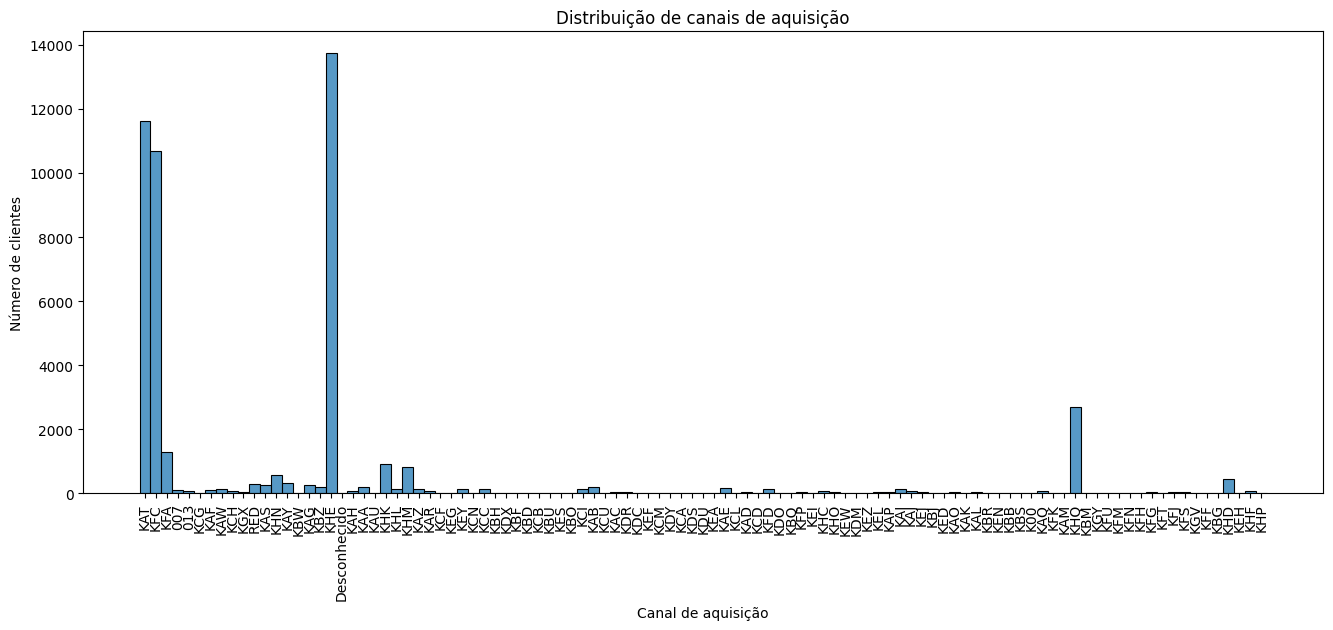

In [12]:
plt.figure(figsize=(16,6))
sns.histplot(data=train, x="canal_aquisicao", bins=30)
plt.title("Distribuição de canais de aquisição")
plt.xlabel("Canal de aquisição")
plt.ylabel("Número de clientes")
plt.xticks(rotation=90)
plt.show()

One-Hot Encoding é **inviável** para esta coluna -> Aplique o Target Encoding (ou Frequency Encoding) nas categorias resultantes (os poucos canais dominantes, Desconhecido, e K_OUTROS_RAROS). Lembre-se de aplicar a codificação com proteção de data leakage (baseando o cálculo do target apenas em dados anteriores).

IMPORTANTE PARA TREINAR MODELO

In [13]:
print("Colunas finais no dataset:\n", train.columns.tolist())

Colunas finais no dataset:
 ['data_referencia', 'id_cliente', 'tipo_empregado', 'pais_residencia', 'sexo', 'idade', 'data_entrada_banco', 'cliente_novo', 'antiguidade_meses', 'tipo_relacionamento', 'relacionamento_mes', 'tipo_relacionamento_mes', 'residente', 'estrangeiro', 'canal_aquisicao', 'codigo_provincia', 'nome_provincia', 'ativo_mes_passado', 'renda_estimativa', 'segmento_marketing', 'conta_corrente', 'conta_nominal', 'conta_terceiros', 'conta_eletronica', 'conta_cobranca_recibos', 'recebimento_recibos', 'renda_estimativa_faltante', 'idade_categoria', 'antiguedade_tempo', 'renda_categoria', 'novas_aquisicoes_count', 'cliente_com_nova_aquisicao']


Agora vemos as colunas sem valores faltantes e dados em seus tipos apropriados

In [14]:
train.head().T

,3565852,5319153,5705103,7450791,8618128
data_referencia,2015-06-28 00:00:00,2015-08-28 00:00:00,2015-09-28 00:00:00,2015-11-28 00:00:00,2015-12-28 00:00:00
id_cliente,16478,16478,16478,16478,16478
tipo_empregado,N,N,N,N,N
pais_residencia,ES,ES,ES,ES,ES
sexo,homem,homem,homem,homem,homem
idade,44.0,44.0,44.0,44.0,44.0
data_entrada_banco,1995-04-03 00:00:00,1995-04-03 00:00:00,1995-04-03 00:00:00,1995-04-03 00:00:00,1995-04-03 00:00:00
cliente_novo,0,0,0,0,0
antiguidade_meses,115.0,116.0,117.0,119.0,120.0
tipo_relacionamento,1.0,1.0,1.0,1.0,1.0


# EDA

## Distribuição de pessoas por idade

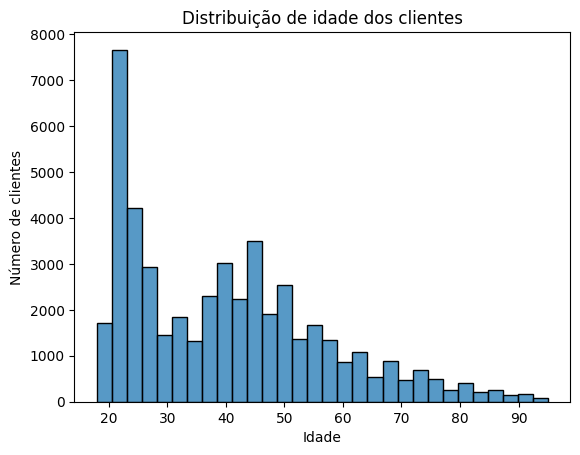

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=train, x="idade", bins=30)
plt.title("Distribuição de idade dos clientes")
plt.xlabel("Idade")
plt.ylabel("Número de clientes")
plt.show()

## Distribuição de pessoas por idade e Sexo

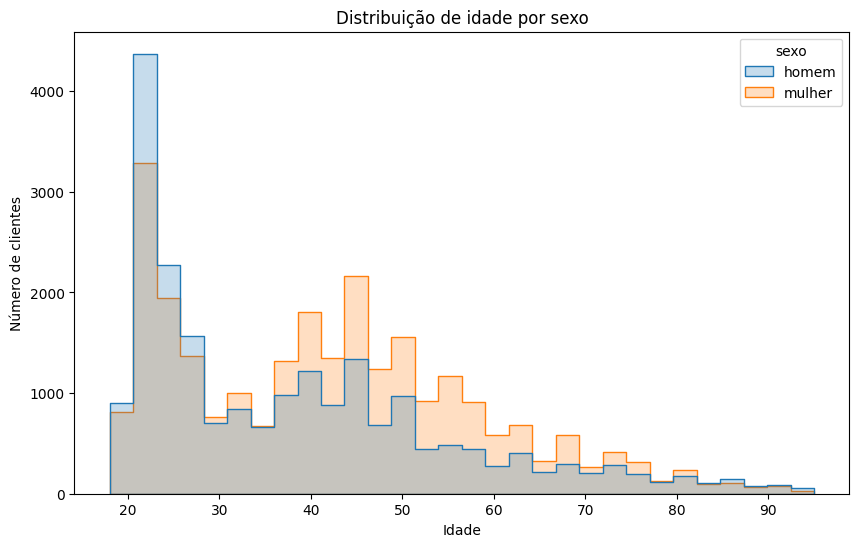

In [16]:
plt.figure(figsize=(10,6))
sns.histplot(data=train, x="idade", hue="sexo", bins=30, element="step")
plt.title("Distribuição de idade por sexo")
plt.xlabel("Idade")
plt.ylabel("Número de clientes")
plt.show()

## Distribuição de renda estimada

Por se tratar de uma renda assimétrica com valores muito grandes que esmagam os dados reais no gráfico, optamos por utilizar Log, pois ele comprime esses valores

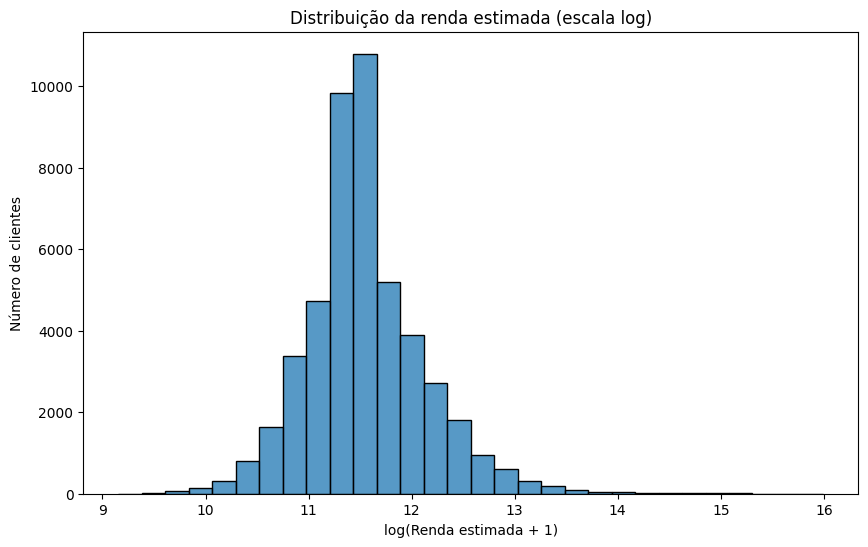

In [17]:
import numpy as np
plt.figure(figsize=(10,6))
sns.histplot(np.log1p(train["renda_estimativa"]), bins=30)
plt.title("Distribuição da renda estimada (escala log)")
plt.xlabel("log(Renda estimada + 1)")
plt.ylabel("Número de clientes")
plt.show()

### Distribuição de Renda por Província

Análise da Renda por Província


,mean,median,count
nome_provincia,,,
MADRID,169555.214597,124685.94,15525
BARCELONA,158902.981033,115267.71,4358
CEUTA,137849.671364,148833.60,22
GIRONA,136233.771900,100861.83,300
"BALEARS, ILLES",127690.389631,106056.36,542


,mean,median,count
nome_provincia,,,
AVILA,77617.507624,70471.11,181
CUENCA,75584.435857,89656.98,251
CACERES,75491.133095,70410.15,378
CIUDAD REAL,75226.974420,71041.29,457
BADAJOZ,72586.725724,70920.09,580


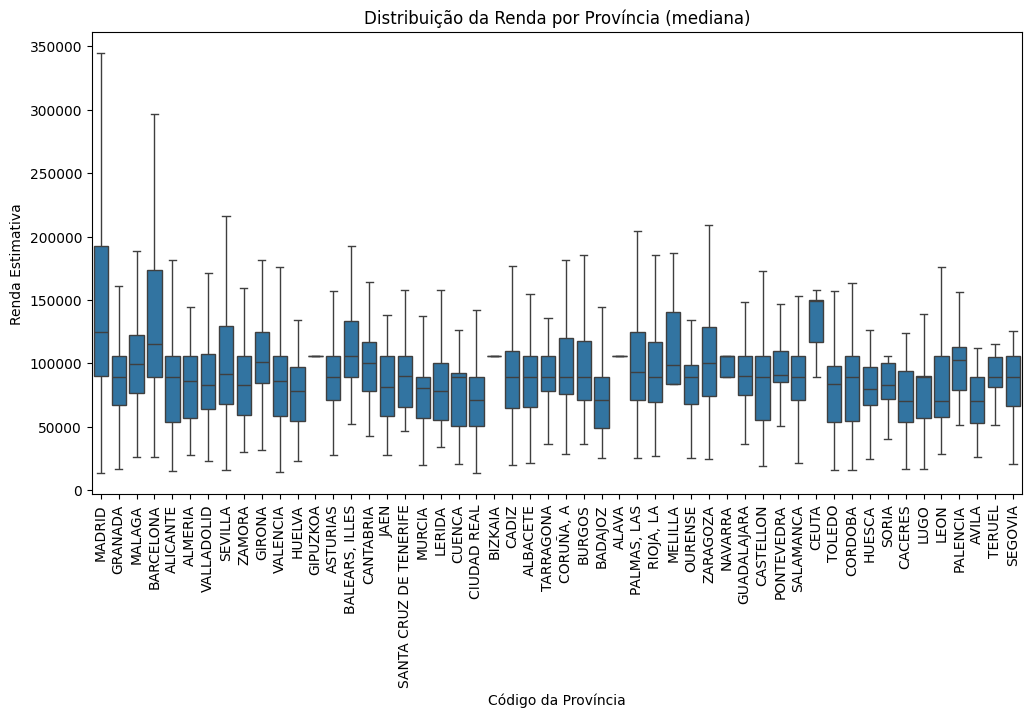

In [18]:
print("Análise da Renda por Província")
renda_por_provincia = train.groupby("nome_provincia")["renda_estimativa"].agg(["mean", "median", "count"]).sort_values(by="mean", ascending=False)

display(renda_por_provincia.head())
display(renda_por_provincia.tail())

plt.figure(figsize=(12, 6))
sns.boxplot(x="nome_provincia", y="renda_estimativa", data=train, showfliers=False)
plt.title("Distribuição da Renda por Província (mediana)")
plt.xlabel("Código da Província")
plt.ylabel("Renda Estimativa")
plt.xticks(rotation=90)
plt.show()

## Proporção de homens e mulheres que contêm os produtos

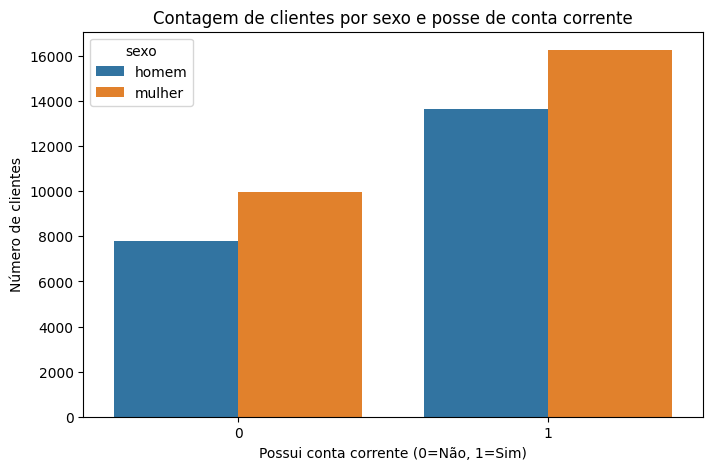

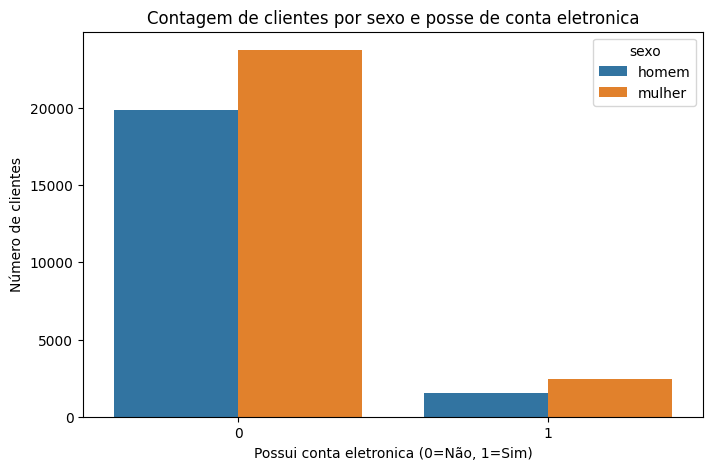

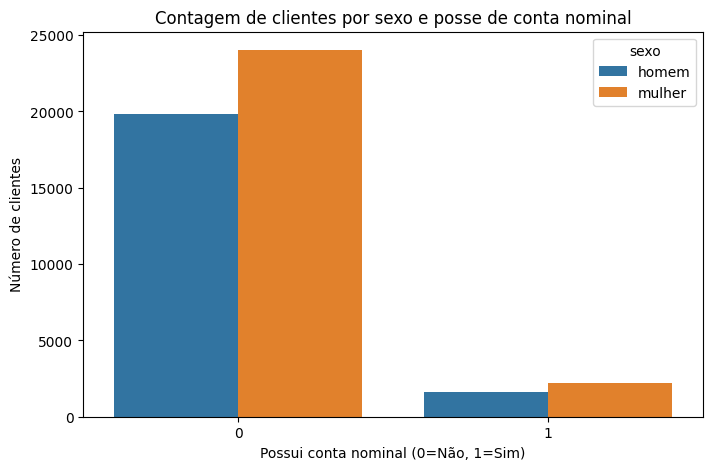

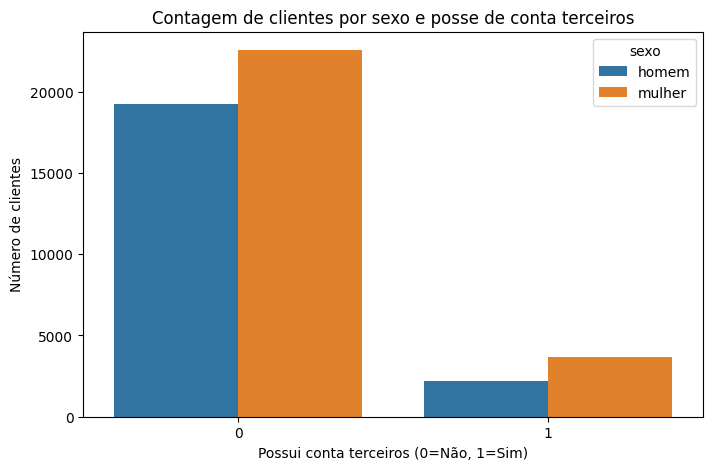

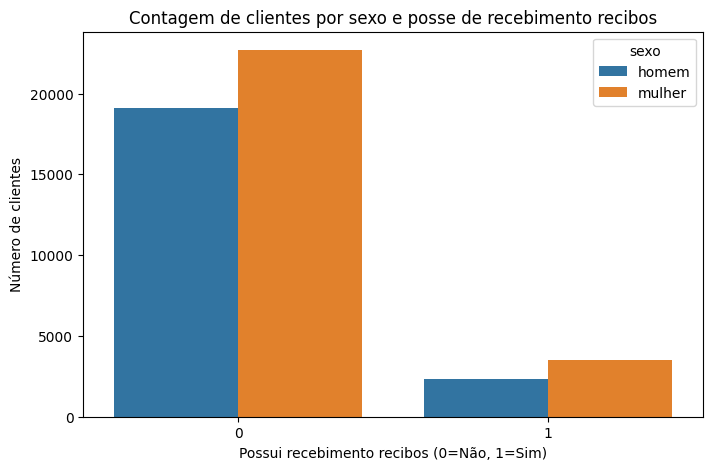

In [19]:
for produto in produtos:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=produto, hue="sexo", data=train)
    plt.title(f"Contagem de clientes por sexo e posse de {produto.replace('_', ' ')}")
    plt.xlabel(f"Possui {produto.replace('_', ' ')} (0=Não, 1=Sim)")
    plt.ylabel("Número de clientes")
    plt.show()

## Renda por segmento de marketing e sexo

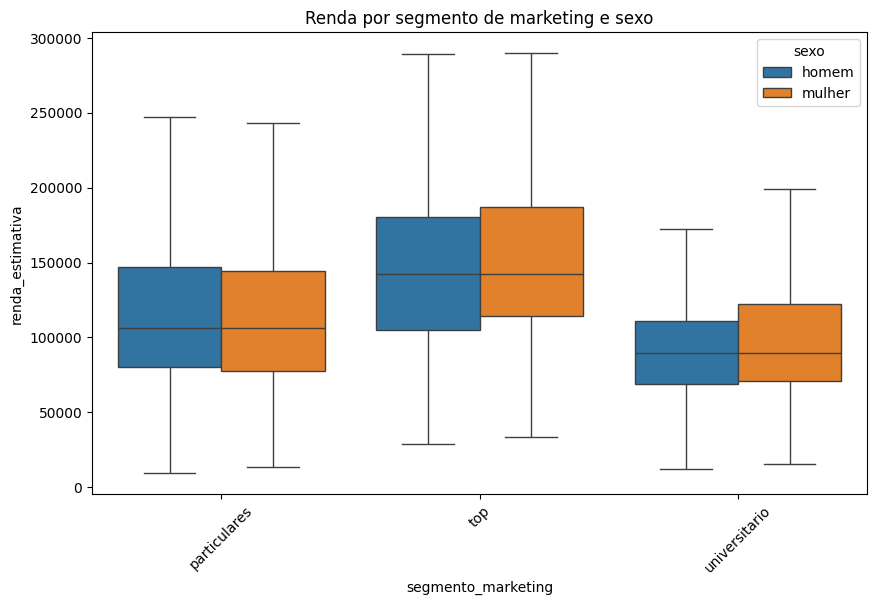

In [20]:
plt.figure(figsize=(10,6))
sns.boxplot(x="segmento_marketing", y="renda_estimativa", hue="sexo", data=train, showfliers=False)
plt.title("Renda por segmento de marketing e sexo")
plt.xticks(rotation=45)
plt.show()

### Distribuição de sexo dentro de cada segmento

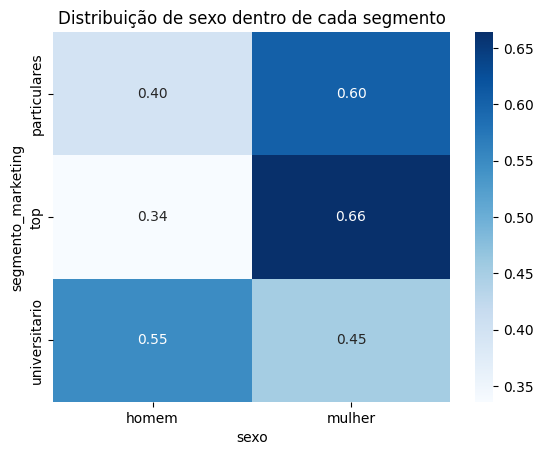

In [21]:
crosstab = pd.crosstab(train["segmento_marketing"], train["sexo"], normalize="index")
sns.heatmap(crosstab, annot=True, cmap="Blues", fmt=".2f")
plt.title("Distribuição de sexo dentro de cada segmento")
plt.show()

In [22]:
for produto in produtos:
  print(f'contagem de {produto}: {(train[produto] == 1).sum()}')


contagem de conta_corrente: 29886
contagem de conta_eletronica: 4007
contagem de conta_nominal: 3781
contagem de conta_terceiros: 5861
contagem de recebimento_recibos: 5831


A base de clientes da amostra está fortemente concentrada em produtos de movimentação e recebimento (conta corrente, conta eletrônica, recebimento de recibos), enquanto produtos de crédito, poupança e investimentos têm adesão muito baixa. Isso pode indicar uma oportunidade de crescimento em produtos financeiros mais diversificados.

In [23]:
# Assumimos que esta lista já está definida e contém todas as 24 colunas binárias.
# Using the already translated product column names
product_cols = produtos

# --- 1. Calcular Aquisição (Crescimento) e Cancelamento (Churn) ---

# Ordenar os dados por cliente e data (necessário para o shift)
train = train.sort_values(['id_cliente', 'data_referencia'])

# Obter o status do produto no mês anterior (M-1)
# O groupby('id_cliente') isola a operação de shift para cada cliente
df_prev = train[product_cols].groupby(train['id_cliente']).shift(1).fillna(0)

# Calcular a diferença (Status M - Status M-1)
df_diff = train[product_cols].fillna(0) - df_prev

# A. Crescimento (Aquisição): Ocorre quando a diferença é +1 (0 -> 1)
df_crescimento = (df_diff == 1).astype(int)

# B. Churn (Cancelamento): Ocorre quando a diferença é -1 (1 -> 0)
df_churn = (df_diff == -1).astype(int)

# 3. Remover os Falsos Positivos de Crescimento (Primeiro Mês de Cliente)
# O primeiro mês de registro de cada cliente (onde df_prev era NaN) deve ser excluído
# Vamos criar uma máscara para identificar o primeiro registro de cada cliente (que deve ser ignorado)
is_first_month = train.duplicated(subset=['id_cliente'], keep='first') == False

# As aquisições no primeiro mês de registro do cliente não são crescimento, são a posse inicial.
# Zere todas as contagens de crescimento para o primeiro mês de cada cliente.
df_crescimento.loc[is_first_month] = 0
df_churn.loc[is_first_month] = 0 # O churn também é zero no primeiro registro.

# --- 2. Agrupamento e Contagem Mensal ---

# Adicionar a coluna de data para agrupar
df_crescimento['data_referencia'] = train['data_referencia']
df_churn['data_referencia'] = train['data_referencia']
total_clientes = train.groupby('data_referencia')['id_cliente'].nunique()


# Agrupar e somar as contagens de crescimento e churn por data de referência
contagem_crescimento = df_crescimento.groupby('data_referencia')[product_cols].sum()
contagem_churn = df_churn.groupby('data_referencia')[product_cols].sum()

print("Contagem de Crescimento Mensal por Produto:")
display(contagem_crescimento)

print("\nContagem de Churn Mensal por Produto:")
display(contagem_churn)

Contagem de Crescimento Mensal por Produto:


,conta_corrente,conta_eletronica,conta_nominal,conta_terceiros,recebimento_recibos
data_referencia,,,,,
2015-06-28,0,0,0,0,0
2015-07-28,4,2,6,0,14
2015-08-28,6,4,9,0,24
2015-09-28,16,2,6,1,30
2015-10-28,21,7,18,1,51
2015-11-28,13,3,14,0,37
2015-12-28,47,15,28,3,54
2016-01-28,35,16,13,4,40
2016-02-28,30,21,12,2,38



Contagem de Churn Mensal por Produto:


,conta_corrente,conta_eletronica,conta_nominal,conta_terceiros,recebimento_recibos
data_referencia,,,,,
2015-06-28,0,0,0,0,0
2015-07-28,4,2,1,1,13
2015-08-28,18,2,3,1,25
2015-09-28,20,5,5,0,18
2015-10-28,34,2,3,4,29
2015-11-28,37,3,6,4,38
2015-12-28,52,3,32,1,31
2016-01-28,36,6,20,4,42
2016-02-28,39,6,18,8,42


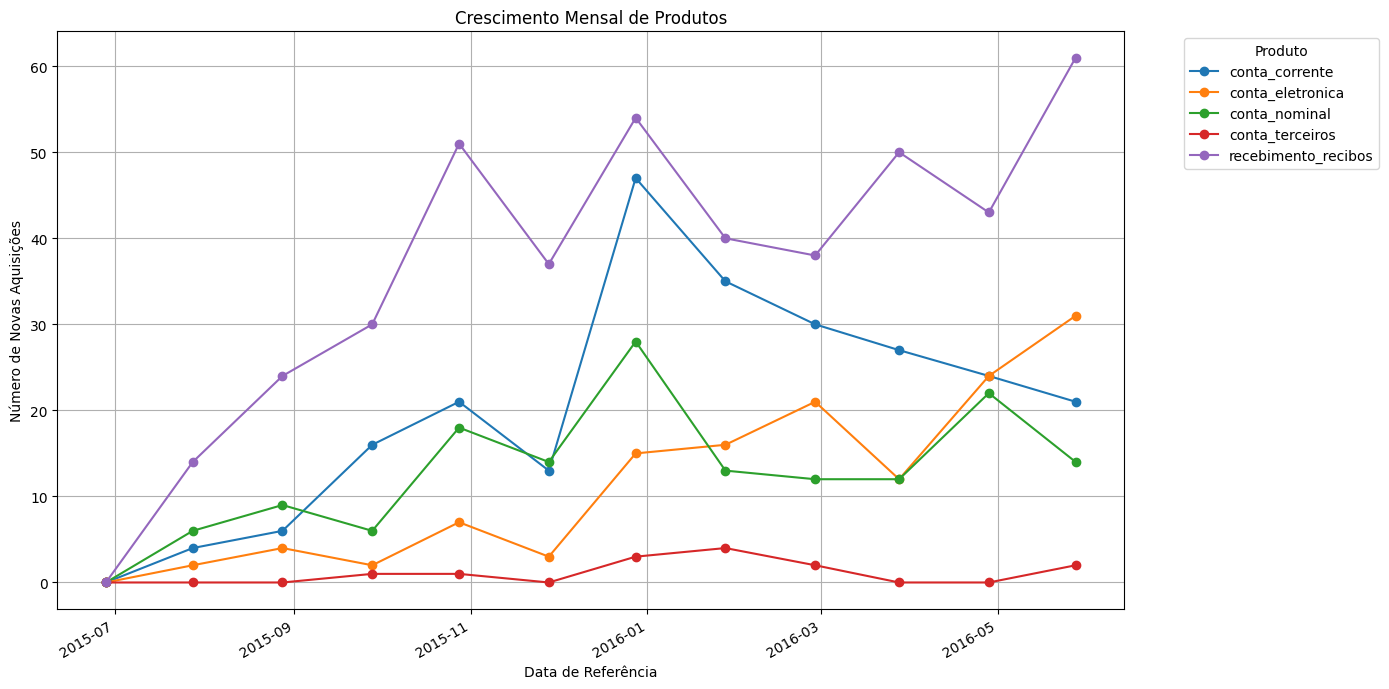

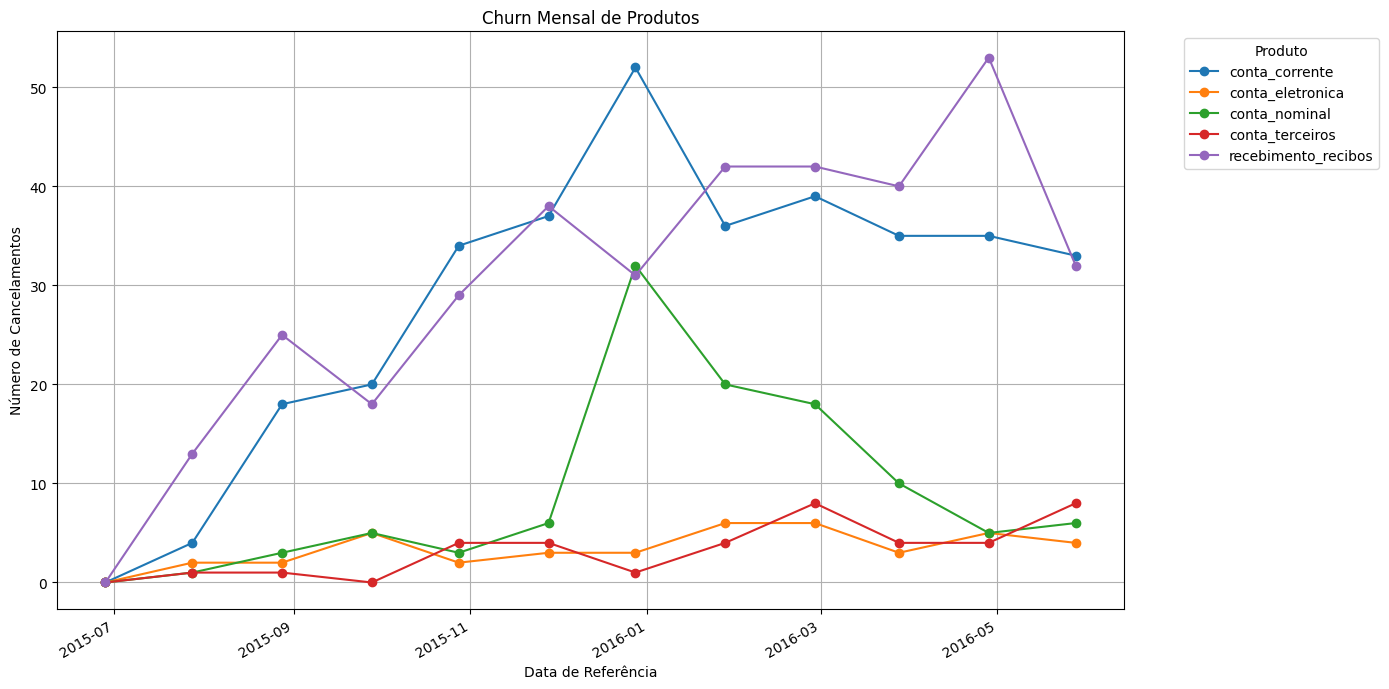

In [24]:
# Plotting the monthly growth
plt.figure(figsize=(14, 7))
contagem_crescimento.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Crescimento Mensal de Produtos')
plt.xlabel('Data de Referência')
plt.ylabel('Número de Novas Aquisições')
plt.grid(True)
plt.legend(title='Produto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plotting the monthly churn
plt.figure(figsize=(14, 7))
contagem_churn.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Churn Mensal de Produtos')
plt.xlabel('Data de Referência')
plt.ylabel('Número de Cancelamentos')
plt.grid(True)
plt.legend(title='Produto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Frequência dos produtos

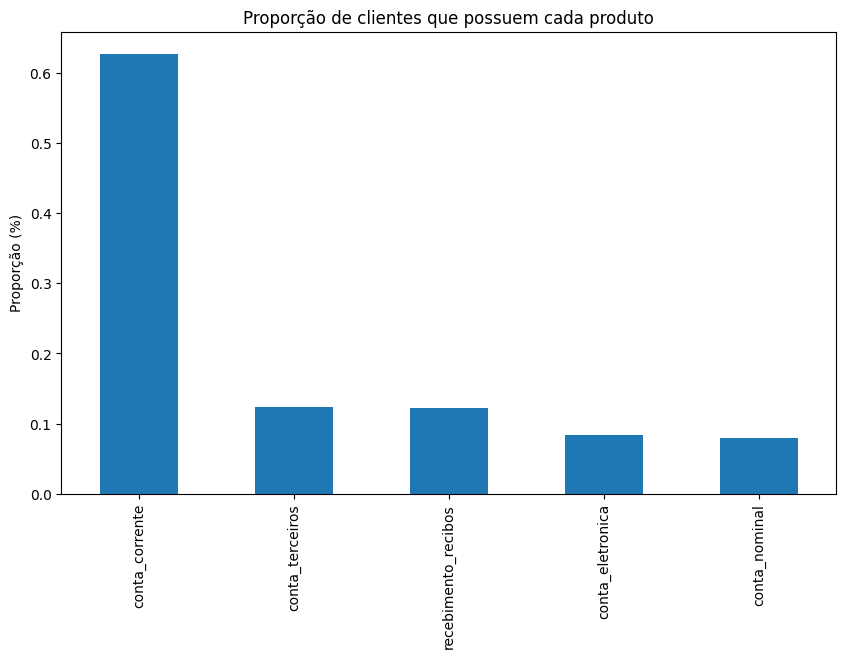

In [25]:
train[produtos].mean().sort_values(ascending=False).plot(kind="bar", figsize=(10,6))
plt.title("Proporção de clientes que possuem cada produto")
plt.ylabel("Proporção (%)")
plt.show()


10%, 20%, etc...

**Produtos Dominantes (Obrigações Bancárias)t**
- Conta corrente -> o produto mais comum, possuído por aproximadamente 65% dos clientes.  Sua posse é quase um pré-requisito ou um forte indicador de que o cliente tem um relacionamento ativo com o banco. O modelo terá muitas informações sobre clientes com este produto.
- recebimento_recibos e conta_terceiros -> os segundos e terceiros mais comuns, com cerca de 12% a 13% de posse. Reforçam a ideia de que os clientes usam o Santander para serviços básicos e de pagamento/transferência.

**Produtos de Risco Médio/Investimento**
- Produtos como deposito_pensao, deposito_salario, cartao_credito e fundo_investimento têm uma proporção significativamente menor (entre 2% e 8%).
- A posse desses produtos deve ser altamente correlacionada com variáveis de perfil, como Renda (renta) e Idade (age). É crucial usar essas features para prever a aquisição desses itens.

**Produtos Raros (Baixa Posse)**
- credito_habitacao, emprestimo_pessoal, deposito_mercado_monetario, conta_poupanca têm uma proporção muito próxima de 0% (menos de 1%)
- Prever a aquisição de um desses produtos será extremamente difícil (severo desequilíbrio). O modelo pode facilmente negligenciá-los. Para esses produtos, as regras de negócio e a Engenharia de Características muito específicas (como features de interação) serão mais importantes do que a posse de produtos comuns.

## Renda por produto

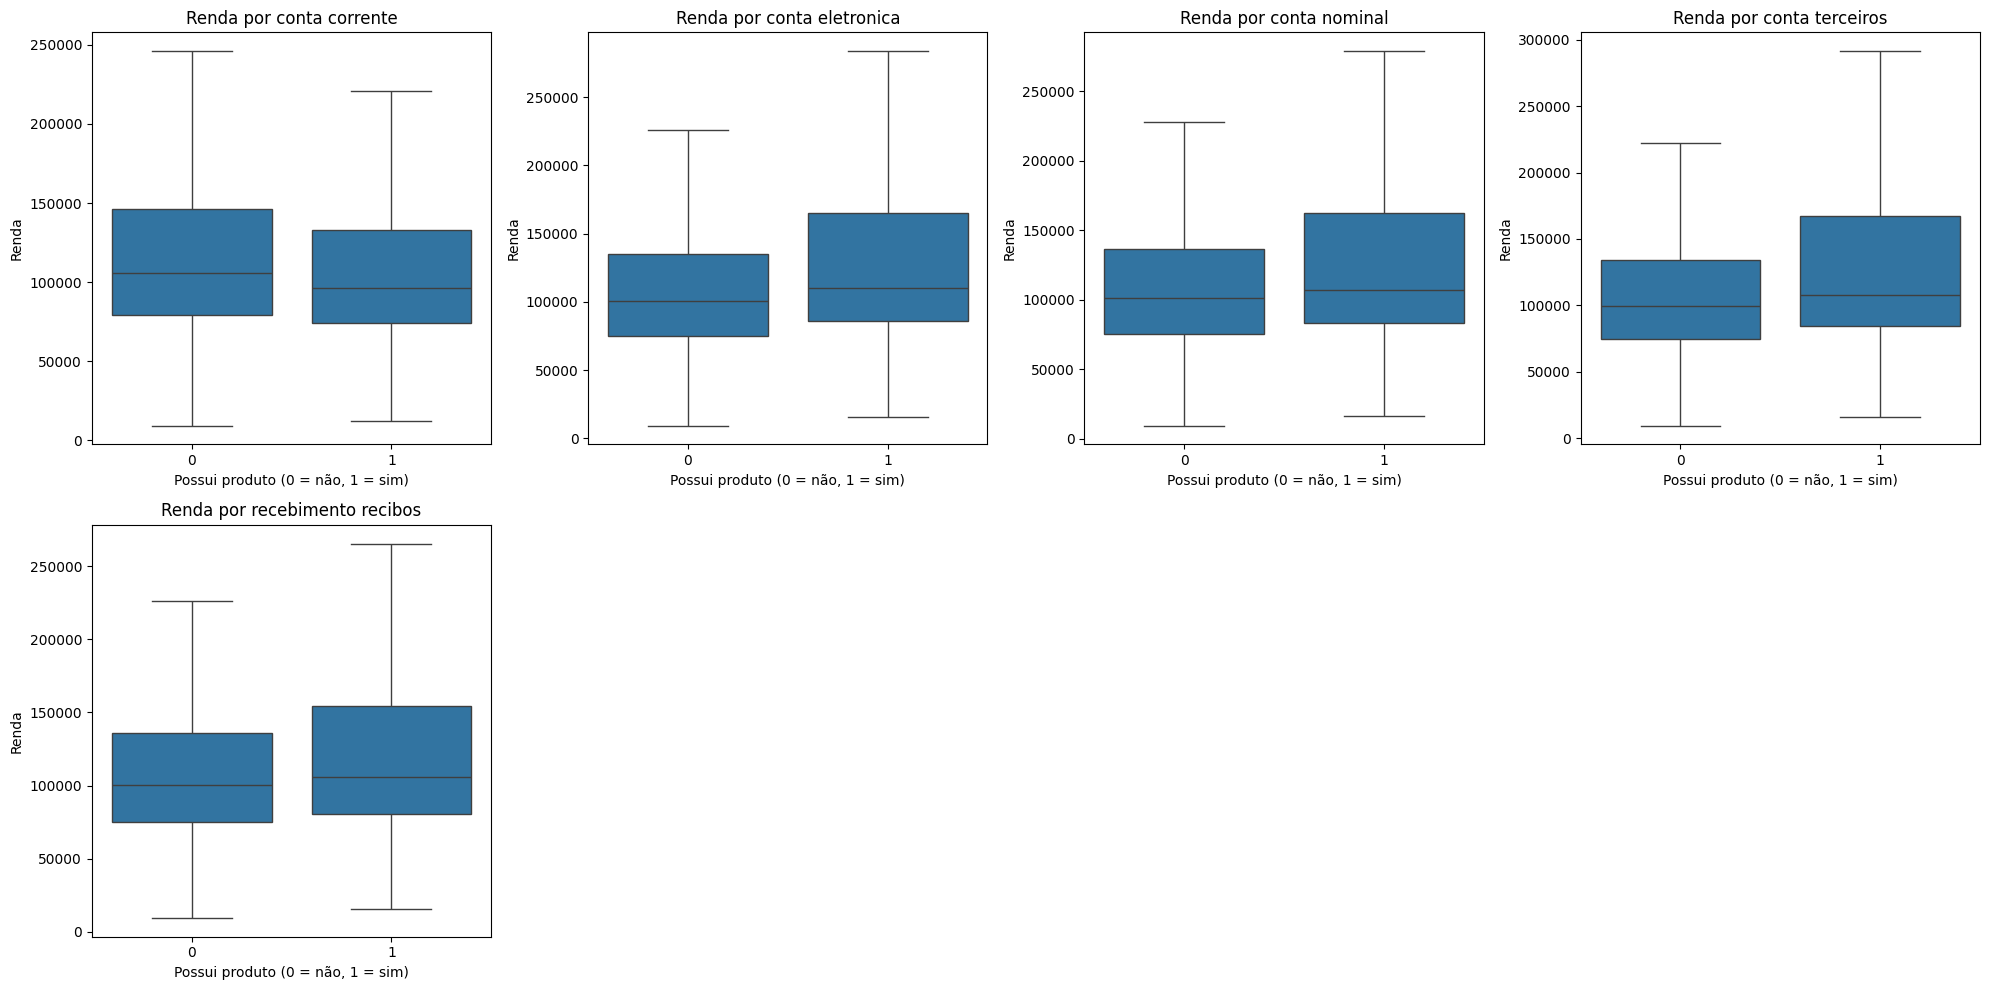

In [26]:

n_produtos = len(produtos)
n_cols = 4
n_rows = (n_produtos + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for j in range(n_produtos, len(axes)):
    fig.delaxes(axes[j])

for i, prod in enumerate(produtos):
    sns.boxplot(x=prod, y="renda_estimativa", data=train, ax=axes[i], showfliers=False)
    axes[i].set_title(f"Renda por {prod.replace('_',' ')}")
    axes[i].set_xlabel("Possui produto (0 = não, 1 = sim)")
    axes[i].set_ylabel("Renda")

plt.tight_layout()
plt.show()

## Distribuição de pessoas por idade, Sexo e segmento

<Figure size 1000x600 with 0 Axes>

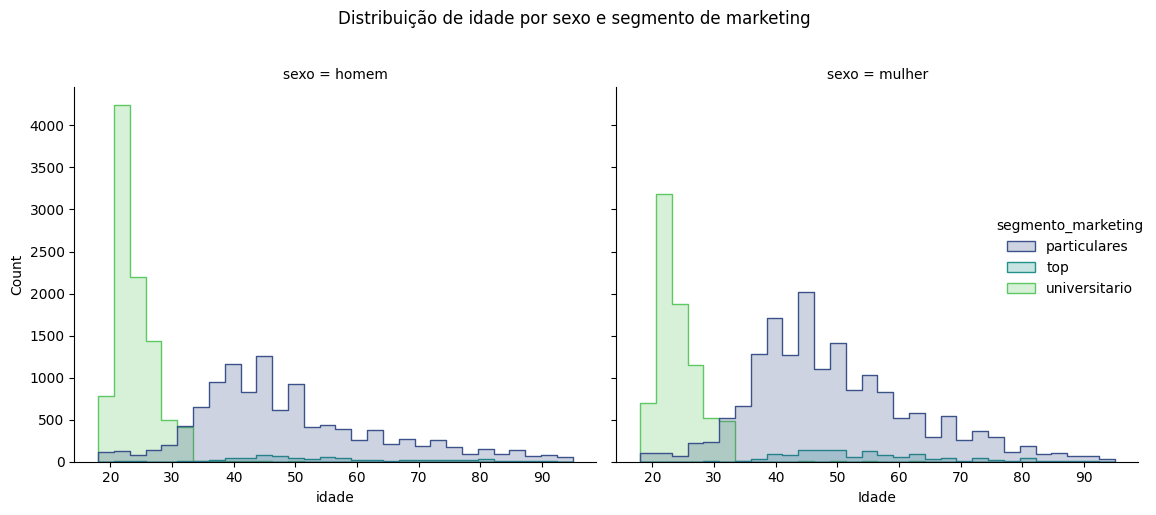

In [27]:
plt.figure(figsize=(10,6))
sns.displot(data=train, x="idade", col="sexo", hue="segmento_marketing", bins=30, element="step", palette="viridis")

plt.suptitle("Distribuição de idade por sexo e segmento de marketing", y=1.02)
plt.xlabel("Idade")
plt.ylabel("Número de clientes")
plt.tight_layout()

plt.show()



## Correlação entre produtos

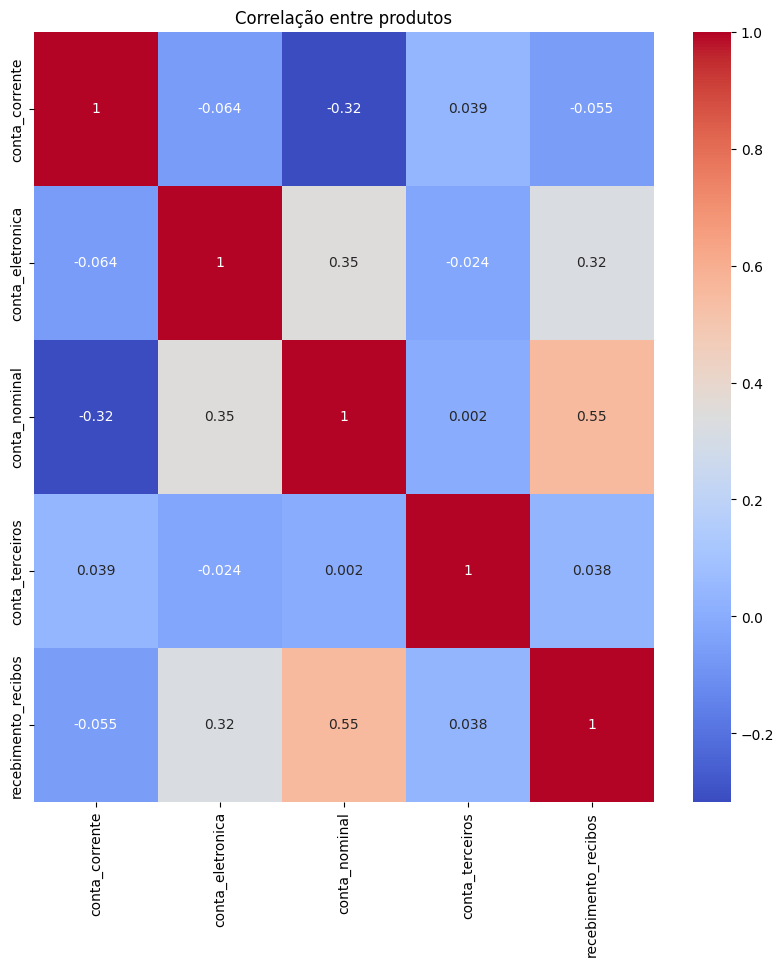

In [28]:

produtos_filtered = [produto for produto in produtos if train[produto].sum() > 0]

corr = train[produtos_filtered].corr()

plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlação entre produtos")
plt.show()

A correlação entre os produtos é muito baixa, porém, alguns tem uma relação forte

Também as correlações entre produto e idade são baixas

## Boxplot para todos os produtos por idade

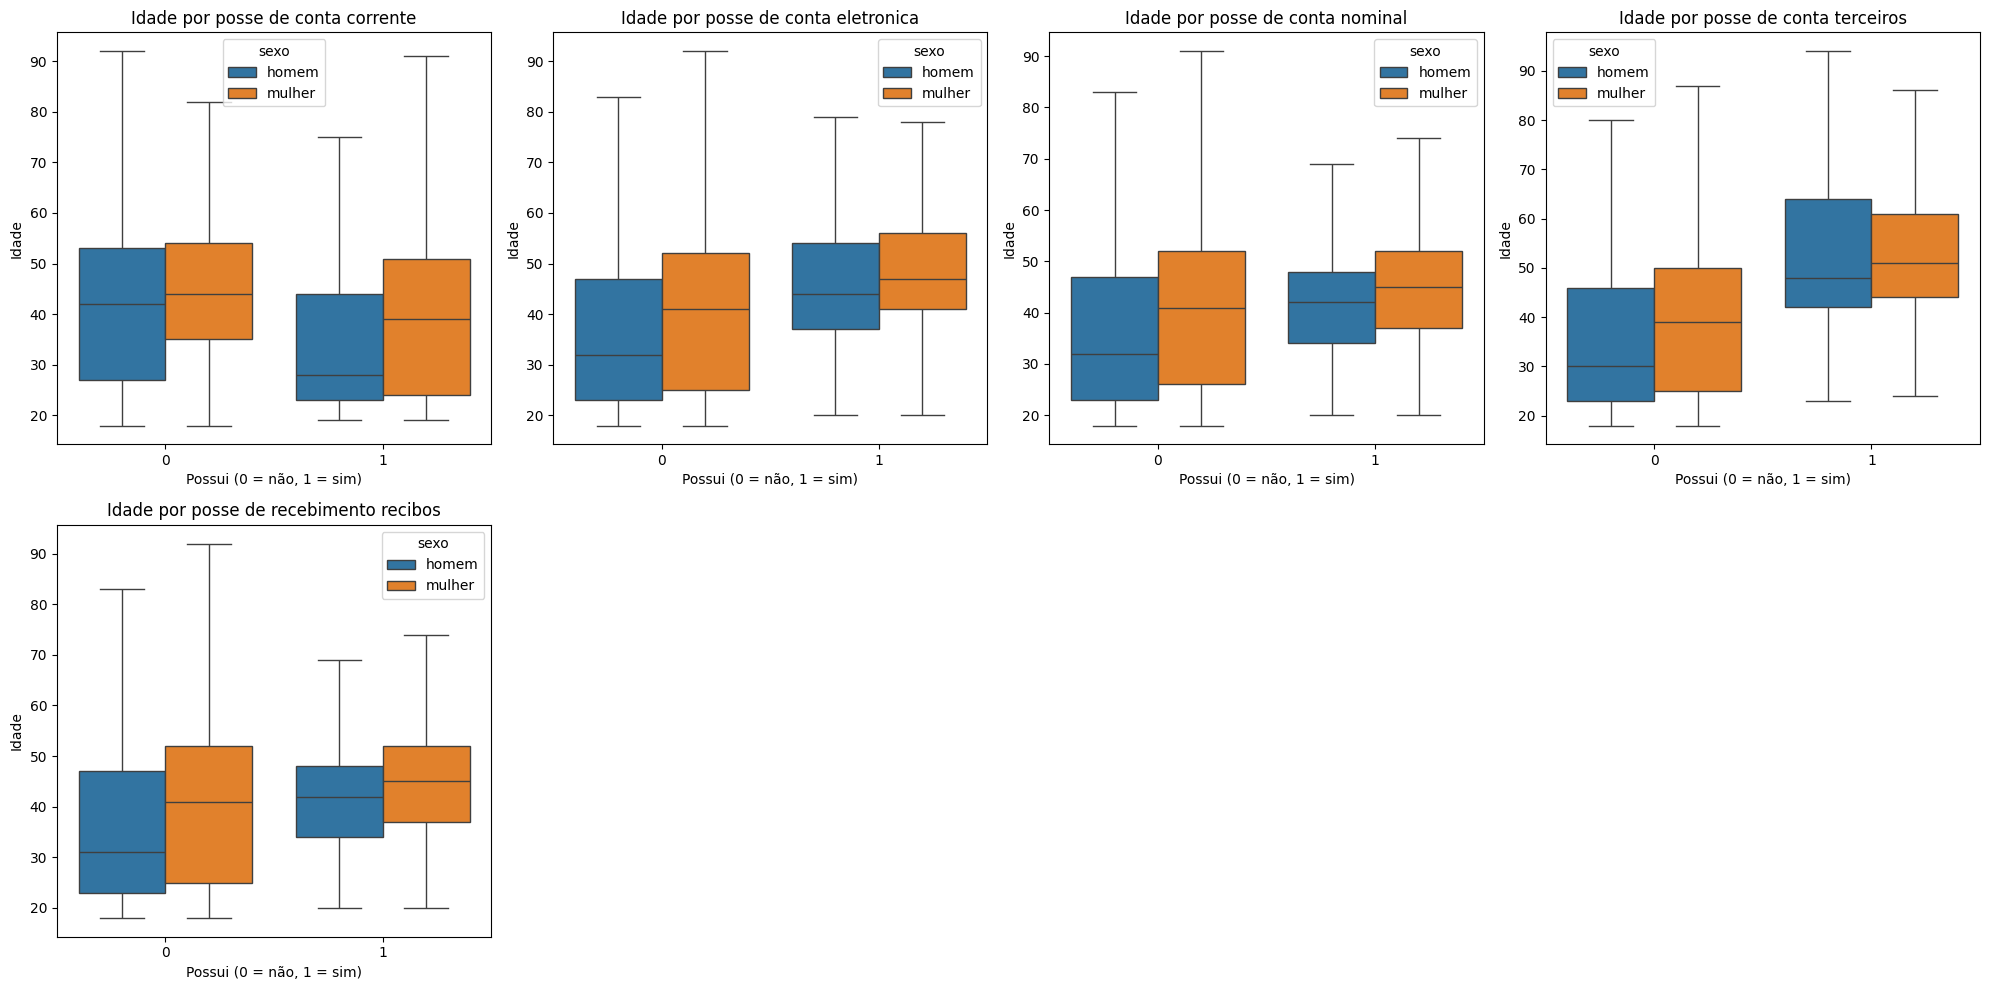

In [29]:
n_produtos = len(produtos)
n_cols = 4
n_rows = (n_produtos + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for j in range(n_produtos, len(axes)):
    fig.delaxes(axes[j])

for i, prod in enumerate(produtos):
    sns.boxplot(
        x=prod,
        y="idade",
        hue="sexo",
        data=train,
        ax=axes[i],
        showfliers=False
    )
    axes[i].set_title(f"Idade por posse de {prod.replace('_',' ')}")
    axes[i].set_xlabel("Possui (0 = não, 1 = sim)")
    axes[i].set_ylabel("Idade")

plt.tight_layout()
plt.show()

## Análise Temporal

### Evolução do número de clientes ativos

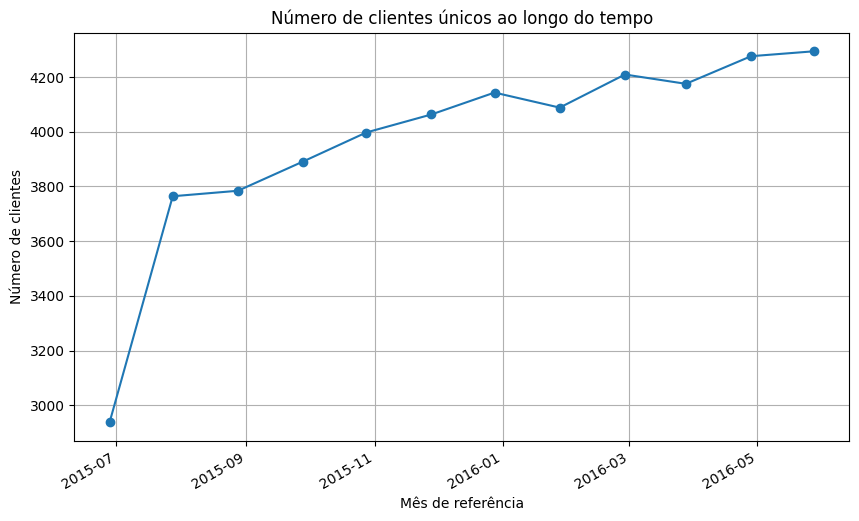

In [30]:
clientes_por_mes = train.groupby("data_referencia")["id_cliente"].nunique()

clientes_por_mes.plot(kind="line", figsize=(10,6), marker="o")
plt.title("Número de clientes únicos ao longo do tempo")
plt.xlabel("Mês de referência")
plt.ylabel("Número de clientes")
plt.grid(True)
plt.show()


Número total de clientes ativos naquele mês

### Evolução de cada produto ao longo do tempo

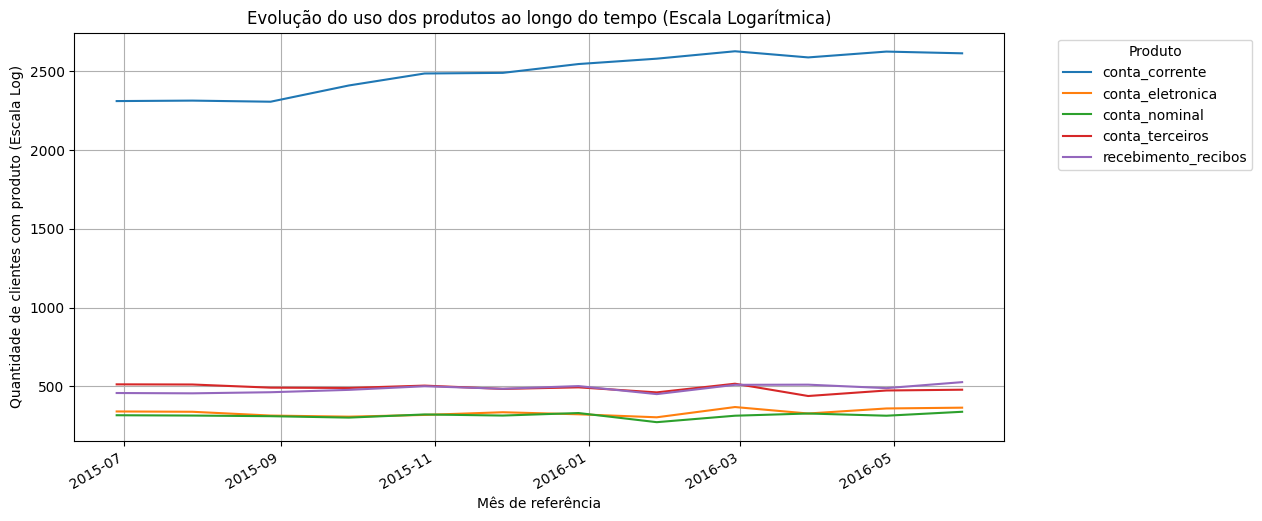

In [31]:
produtos_mes = train.groupby("data_referencia")[produtos].sum()

produtos_mes.plot(figsize=(12,6))
plt.title("Evolução do uso dos produtos ao longo do tempo (Escala Logarítmica)")
plt.xlabel("Mês de referência")
plt.ylabel("Quantidade de clientes com produto (Escala Log)")
plt.legend(title="Produto", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

#### Em escala Log para melhor visualização

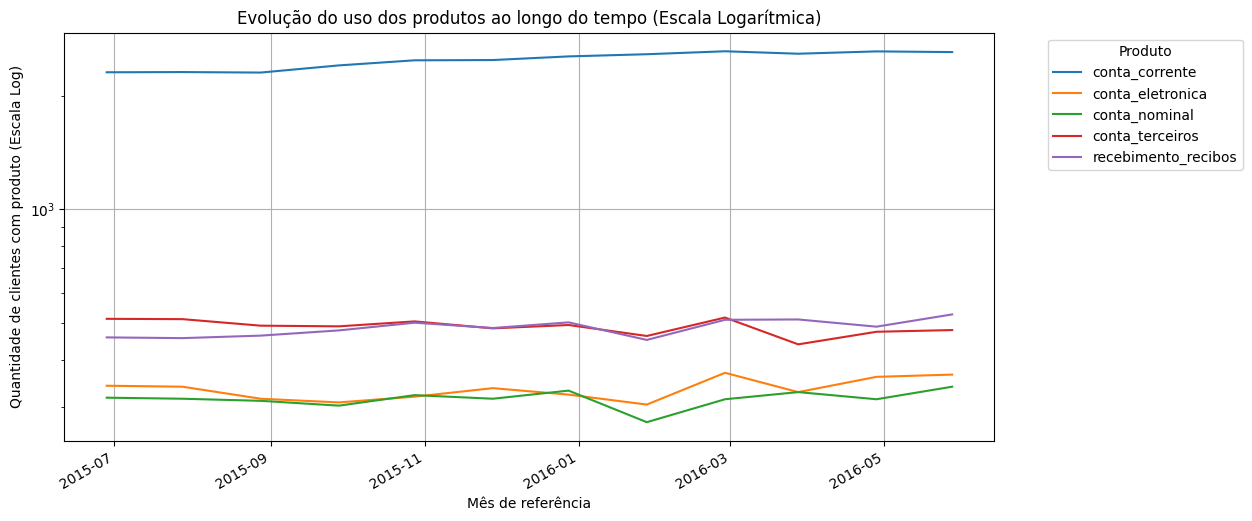

In [32]:
produtos_mes.plot(figsize=(12,6))
plt.title("Evolução do uso dos produtos ao longo do tempo (Escala Logarítmica)")
plt.xlabel("Mês de referência")
plt.ylabel("Quantidade de clientes com produto (Escala Log)")
plt.yscale('log') # Set the y-axis to a logarithmic scale
plt.legend(title="Produto", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

### Tempo médio de relacionamento

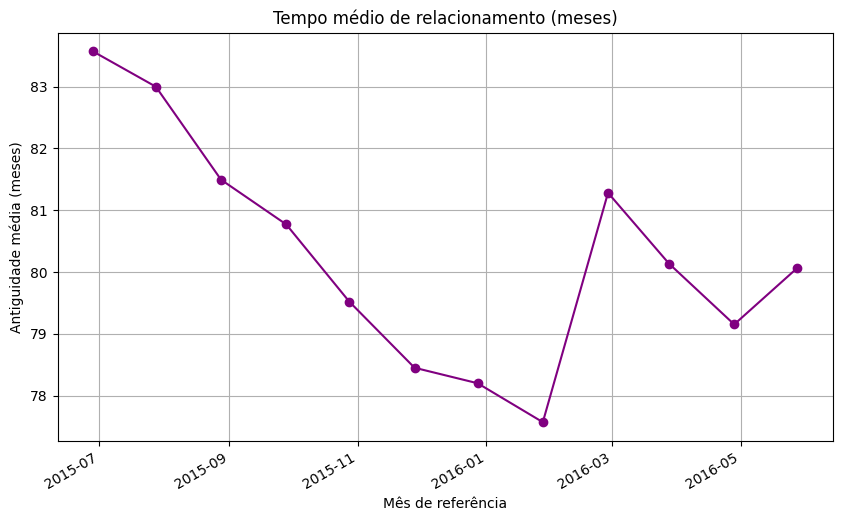

In [33]:
tempo_medio = train.groupby("data_referencia")["antiguidade_meses"].mean()

tempo_medio.plot(kind="line", figsize=(10,6), marker="o", color="purple")
plt.title("Tempo médio de relacionamento (meses)")
plt.xlabel("Mês de referência")
plt.ylabel("Antiguidade média (meses)")
plt.grid(True)
plt.show()


### Proporção de clientes por segmento ao longo do tempo

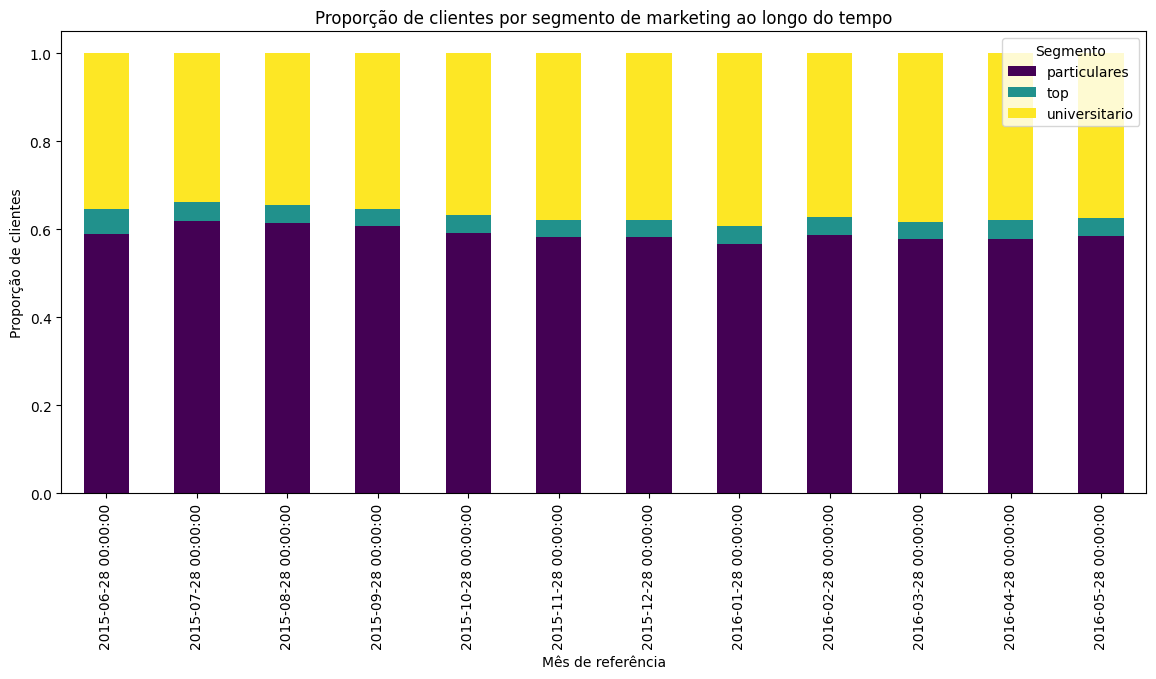

In [34]:
seg_por_mes = pd.crosstab(train["data_referencia"], train["segmento_marketing"], normalize="index")

seg_por_mes.plot(kind="bar", stacked=True, figsize=(14,6), colormap="viridis")
plt.title("Proporção de clientes por segmento de marketing ao longo do tempo")
plt.xlabel("Mês de referência")
plt.ylabel("Proporção de clientes")
plt.legend(title="Segmento")
plt.show()


Se em jan/2015 você tem 70% particulares, 20% universitários e 10% top, a soma dá 1.0.

In [35]:
train['nome_provincia'].unique()

array(['MADRID', 'GRANADA', 'MALAGA', 'BARCELONA', 'ALICANTE', 'ALMERIA',
       'VALLADOLID', 'SEVILLA', 'ZAMORA', 'GIRONA', 'VALENCIA', 'HUELVA',
       'GIPUZKOA', 'ASTURIAS', 'BALEARS, ILLES', 'CANTABRIA', 'JAEN',
       'SANTA CRUZ DE TENERIFE', 'MURCIA', 'LERIDA', 'CUENCA',
       'CIUDAD REAL', 'BIZKAIA', 'CADIZ', 'ALBACETE', 'TARRAGONA',
       'CORUÑA, A', 'BURGOS', 'BADAJOZ', 'ALAVA', 'PALMAS, LAS',
       'RIOJA, LA', 'MELILLA', 'OURENSE', 'ZARAGOZA', 'NAVARRA',
       'GUADALAJARA', 'CASTELLON', 'PONTEVEDRA', 'SALAMANCA', 'CEUTA',
       'TOLEDO', 'CORDOBA', 'HUESCA', 'SORIA', 'CACERES', 'LUGO', 'LEON',
       'PALENCIA', 'AVILA', 'TERUEL', 'SEGOVIA'], dtype=object)

# Preparação dos dados para Treinamento

## Preparação de Dados

### Features de Antiguidade e Tempo

#### Categorização do tempo do cliente

In [36]:
bins = [0, 6, 12, 36, train['antiguidade_meses'].max()]
labels = ['0-6 meses', '6-12 meses', '1-3 anos', '> 3 anos']

train['antiguidade_faixas'] = pd.cut(train['antiguidade_meses'], bins=bins, labels=labels, right=False)

print("Contagem de clientes por faixa de antiguidade:")
display(train['antiguidade_faixas'].value_counts())

Contagem de clientes por faixa de antiguidade:


,count
antiguidade_faixas,
> 3 anos,30246
1-3 anos,11535
6-12 meses,2987
0-6 meses,2853


#### Tempo desde a inscrição em meses

In [37]:
train['tempo_desde_alta'] = ((train['data_referencia'] - train['data_entrada_banco']).dt.days / 30.44).round().astype(int)

print("Nova feature 'tempo_desde_alta' criada.")
display(train[['data_referencia', 'data_entrada_banco', 'tempo_desde_alta']].head())

Nova feature 'tempo_desde_alta' criada.


,data_referencia,data_entrada_banco,tempo_desde_alta
3565852,2015-06-28,1995-04-03,243
5319153,2015-08-28,1995-04-03,245
5705103,2015-09-28,1995-04-03,246
7450791,2015-11-28,1995-04-03,248
8618128,2015-12-28,1995-04-03,249


In [38]:
bins = [18, 26, 41, 61, train['idade'].max() + 1]
labels = ['18-25', '26-40', '41-60', '>60']

train['idade_faixas'] = pd.cut(train['idade'], bins=bins, labels=labels, right=False)

print("Contagem de clientes por faixa de idade:")
display(train['idade_faixas'].value_counts())

Contagem de clientes por faixa de idade:


,count
idade_faixas,
41-60,16105
18-25,13586
26-40,11793
>60,6138


#### Identificar produtos que são o target (novas aquisições)

In [39]:
train = train.sort_values(['id_cliente', 'data_referencia'])

train_prev_month = train.groupby('id_cliente')[produtos].shift(1).fillna(0) ## mês posterior

train_prev_month.columns = [f'{p}_prev' for p in produtos]

train = pd.concat([train, train_prev_month], axis=1)

for produto in produtos:
    train[f'{produto}_new'] = ((train[produto] == 1) & (train[f'{produto}_prev'] == 0)).astype(int) ## para cada produto identifica novas aquisições

target_cols = [f'{p}_new' for p in produtos]

print("\nDataFrame com novas aquisições:")
display(train.head())

print("\nContagem de novas aquisições por produto:")
display(train[target_cols].sum().sort_values(ascending=False))


DataFrame com novas aquisições:


,data_referencia,id_cliente,tipo_empregado,pais_residencia,sexo,idade,data_entrada_banco,cliente_novo,antiguidade_meses,tipo_relacionamento,...,conta_corrente_prev,conta_eletronica_prev,conta_nominal_prev,conta_terceiros_prev,recebimento_recibos_prev,conta_corrente_new,conta_eletronica_new,conta_nominal_new,conta_terceiros_new,recebimento_recibos_new
3565852,2015-06-28,16478,N,ES,homem,44.0,1995-04-03,0,115.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0
5319153,2015-08-28,16478,N,ES,homem,44.0,1995-04-03,0,116.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0
5705103,2015-09-28,16478,N,ES,homem,44.0,1995-04-03,0,117.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0
7450791,2015-11-28,16478,N,ES,homem,44.0,1995-04-03,0,119.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0
8618128,2015-12-28,16478,N,ES,homem,44.0,1995-04-03,0,120.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0



Contagem de novas aquisições por produto:


,0
conta_corrente_new,7410
recebimento_recibos_new,1754
conta_terceiros_new,1366
conta_nominal_new,1021
conta_eletronica_new,1017


Para cada cliente, comparamos os produtos que ele possuía em um determinado mês com o mês anterior.

Para cada produtos, identificar qual foi adquirido no mês atual (1), mas não no mês posterior (0).

### Features de Renda

#### Transformação da Renda em log

In [40]:
train['renda_log'] = np.log1p(train['renda_estimativa'])

print("\nDataFrame com a nova feature 'renda_log':")
display(train[['renda_estimativa', 'renda_log']].head())


DataFrame com a nova feature 'renda_log':


,renda_estimativa,renda_log
3565852,152306.67,11.933658
5319153,152306.67,11.933658
5705103,152306.67,11.933658
7450791,152306.67,11.933658
8618128,152306.67,11.933658


Para normalizar a distribuição, reduzindo o impacto de outliers

#### Variação percentual da renda do cliente em relação ao mês anterior

In [41]:
train['renda_variacao'] = train.groupby('id_cliente')['renda_estimativa'].pct_change().fillna(0)

print("\nDataFrame com a nova feature 'renda_variacao':")
display(train[['id_cliente', 'data_referencia', 'renda_estimativa', 'renda_variacao']].head())


DataFrame com a nova feature 'renda_variacao':


,id_cliente,data_referencia,renda_estimativa,renda_variacao
3565852,16478,2015-06-28,152306.67,0.0
5319153,16478,2015-08-28,152306.67,0.0
5705103,16478,2015-09-28,152306.67,0.0
7450791,16478,2015-11-28,152306.67,0.0
8618128,16478,2015-12-28,152306.67,0.0


#### Categorização da renda (alta, baixa, media)

In [42]:
bins = train['renda_estimativa'].quantile([0, 0.33, 0.66, 1]).tolist()
labels = ['baixa', 'média', 'alta']

train['renda_faixas'] = pd.cut(train['renda_estimativa'], bins=bins, labels=labels, include_lowest=True)

print("\nContagem de clientes por faixa de renda:")
display(train['renda_faixas'].value_counts())

print("\nDataFrame com a nova feature 'renda_faixas':")
display(train[['renda_estimativa', 'renda_faixas']].head())


Contagem de clientes por faixa de renda:


,count
renda_faixas,
alta,16188
média,15718
baixa,15716



DataFrame com a nova feature 'renda_faixas':


,renda_estimativa,renda_faixas
3565852,152306.67,alta
5319153,152306.67,alta
5705103,152306.67,alta
7450791,152306.67,alta
8618128,152306.67,alta


### Features de Interação e Co-ocorrência

#### Coluna binária de clientes que possuem produtos de alta co-ocorrencia

In [43]:
train['possui_pacote_basico'] = ((train['conta_corrente'] == 1) & (train['recebimento_recibos'] == 1)).astype(int)

print("\nDataFrame com a nova feature 'possui_pacote_basico':")
display(train[['conta_corrente', 'recebimento_recibos', 'possui_pacote_basico']].head())

print("\nContagem de clientes que possuem o 'pacote_basico':")
display(train['possui_pacote_basico'].value_counts())


DataFrame com a nova feature 'possui_pacote_basico':


,conta_corrente,recebimento_recibos,possui_pacote_basico
3565852,1,0,0
5319153,1,0,0
5705103,1,0,0
7450791,1,0,0
8618128,1,0,0



Contagem de clientes que possuem o 'pacote_basico':


,count
possui_pacote_basico,
0,44375
1,3247


#### Feature de relação de produto e idade

In [44]:
train['segmento_idade'] = train['segmento_marketing'].astype(str) + '_' + train['idade_faixas'].astype(str)

product_cols = [
    "conta_corrente", "conta_eletronica", "conta_nominal", "conta_terceiros", "recebimento_recibos"
]

for prod in product_cols:
    train[f'{prod}_idade_interacao'] = train[prod] * train['idade']

print("\nDataFrame with interaction features:")
display(train[['segmento_idade'] + [f'{prod}_idade_interacao' for prod in product_cols]].head())


DataFrame with interaction features:


,segmento_idade,conta_corrente_idade_interacao,conta_eletronica_idade_interacao,conta_nominal_idade_interacao,conta_terceiros_idade_interacao,recebimento_recibos_idade_interacao
3565852,particulares_41-60,44.0,0.0,0.0,0.0,0.0
5319153,particulares_41-60,44.0,0.0,0.0,0.0,0.0
5705103,particulares_41-60,44.0,0.0,0.0,0.0,0.0
7450791,particulares_41-60,44.0,0.0,0.0,0.0,0.0
8618128,particulares_41-60,44.0,0.0,0.0,0.0,0.0


#### Features de Posse de Produtos Anteriores.

In [45]:
train = train.sort_values(['id_cliente', 'data_referencia'])

train_prev_month = train.groupby('id_cliente')[product_cols].shift(1)

train_prev_month.columns = [f'{p}_mes_anterior' for p in product_cols]

train = pd.concat([train, train_prev_month], axis=1)

train[train_prev_month.columns] = train[train_prev_month.columns].fillna(0)


print("\nDataFrame com features de posse de produtos no mês anterior:")
display(train.head())

print("\nColunas adicionadas:")
print(train_prev_month.columns.tolist())


DataFrame com features de posse de produtos no mês anterior:


,data_referencia,id_cliente,tipo_empregado,pais_residencia,sexo,idade,data_entrada_banco,cliente_novo,antiguidade_meses,tipo_relacionamento,...,conta_corrente_idade_interacao,conta_eletronica_idade_interacao,conta_nominal_idade_interacao,conta_terceiros_idade_interacao,recebimento_recibos_idade_interacao,conta_corrente_mes_anterior,conta_eletronica_mes_anterior,conta_nominal_mes_anterior,conta_terceiros_mes_anterior,recebimento_recibos_mes_anterior
3565852,2015-06-28,16478,N,ES,homem,44.0,1995-04-03,0,115.0,1.0,...,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5319153,2015-08-28,16478,N,ES,homem,44.0,1995-04-03,0,116.0,1.0,...,44.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5705103,2015-09-28,16478,N,ES,homem,44.0,1995-04-03,0,117.0,1.0,...,44.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7450791,2015-11-28,16478,N,ES,homem,44.0,1995-04-03,0,119.0,1.0,...,44.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8618128,2015-12-28,16478,N,ES,homem,44.0,1995-04-03,0,120.0,1.0,...,44.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0



Colunas adicionadas:
['conta_corrente_mes_anterior', 'conta_eletronica_mes_anterior', 'conta_nominal_mes_anterior', 'conta_terceiros_mes_anterior', 'recebimento_recibos_mes_anterior']


O modelo saberá exatamente o que o cliente tinha no momento da previsão, que é o preditor mais forte para recomendação (a posse de um produto aumenta a probabilidade de aquisição de produtos complementares).

### Ordinal Encoding

In [46]:
from sklearn.preprocessing import OrdinalEncoder

idade_order = ['Jovem', 'Jovem_Adulto', 'Adulto', 'Meia_Idade', 'Idoso']

renda_order = ['Baixa', 'Media_Baixa', 'Media_Alta', 'Alta']


encoder_idade = OrdinalEncoder(categories=[idade_order])
encoder_renda = OrdinalEncoder(categories=[renda_order])

train['idade_categoria_encoded'] = encoder_idade.fit_transform(train[['idade_categoria']])
train['renda_categoria_encoded'] = encoder_renda.fit_transform(train[['renda_categoria']])

print("Ordinal Encoding aplicado para 'idade_categoria' e 'renda_categoria'.")
display(train[['idade_categoria', 'idade_categoria_encoded', 'renda_categoria', 'renda_categoria_encoded']].head())

Ordinal Encoding aplicado para 'idade_categoria' e 'renda_categoria'.


,idade_categoria,idade_categoria_encoded,renda_categoria,renda_categoria_encoded
3565852,Adulto,2.0,Alta,3.0
5319153,Adulto,2.0,Alta,3.0
5705103,Adulto,2.0,Alta,3.0
7450791,Adulto,2.0,Alta,3.0
8618128,Adulto,2.0,Alta,3.0


### TARGET ENCODING -> substitui cada categoria pela média

In [47]:
categorical_for_encoding = [
    "canal_aquisicao",
    "codigo_provincia",
    "nome_provincia",
    "relacionamento_mes",
    "tipo_relacionamento_mes",
    "segmento_marketing",
    "segmento_idade"

]

C = 100

for col in categorical_for_encoding:
    print(f"Aplicando Target Encoding (Suavizado) para '{col}'...")

    train[col] = train[col].fillna("missing_category")

    for product_col in target_cols:
        cumulative_sum = train.groupby(col)[product_col].cumsum().shift(1).fillna(0)

        cumulative_count = train.groupby(col).cumcount()

        global_mean = train[product_col].mean()

        smoothed_target_encoding = (cumulative_sum + C * global_mean) / (cumulative_count + C)

        feature_name = f"TE_{col}_{product_col.replace('_new', '')}"

        train[feature_name] = smoothed_target_encoding

print("\nTarget Encoding aplicado com proteção temporal (Data Leakage evitado).")
display(train.head())

Aplicando Target Encoding (Suavizado) para 'canal_aquisicao'...
Aplicando Target Encoding (Suavizado) para 'codigo_provincia'...
Aplicando Target Encoding (Suavizado) para 'nome_provincia'...
Aplicando Target Encoding (Suavizado) para 'relacionamento_mes'...
Aplicando Target Encoding (Suavizado) para 'tipo_relacionamento_mes'...
Aplicando Target Encoding (Suavizado) para 'segmento_marketing'...
Aplicando Target Encoding (Suavizado) para 'segmento_idade'...

Target Encoding aplicado com proteção temporal (Data Leakage evitado).


,data_referencia,id_cliente,tipo_empregado,pais_residencia,sexo,idade,data_entrada_banco,cliente_novo,antiguidade_meses,tipo_relacionamento,...,TE_segmento_marketing_conta_corrente,TE_segmento_marketing_conta_eletronica,TE_segmento_marketing_conta_nominal,TE_segmento_marketing_conta_terceiros,TE_segmento_marketing_recebimento_recibos,TE_segmento_idade_conta_corrente,TE_segmento_idade_conta_eletronica,TE_segmento_idade_conta_nominal,TE_segmento_idade_conta_terceiros,TE_segmento_idade_recebimento_recibos
3565852,2015-06-28,16478,N,ES,homem,44.0,1995-04-03,0,115.0,1.0,...,0.155600,0.021356,0.021440,0.028684,0.036832,0.155600,0.021356,0.021440,0.028684,0.036832
5319153,2015-08-28,16478,N,ES,homem,44.0,1995-04-03,0,116.0,1.0,...,0.163961,0.021144,0.021227,0.028400,0.036467,0.163961,0.021144,0.021227,0.028400,0.036467
5705103,2015-09-28,16478,N,ES,homem,44.0,1995-04-03,0,117.0,1.0,...,0.162353,0.020937,0.021019,0.028122,0.036110,0.162353,0.020937,0.021019,0.028122,0.036110
7450791,2015-11-28,16478,N,ES,homem,44.0,1995-04-03,0,119.0,1.0,...,0.160777,0.020734,0.020815,0.027849,0.035759,0.160777,0.020734,0.020815,0.027849,0.035759
8618128,2015-12-28,16478,N,ES,homem,44.0,1995-04-03,0,120.0,1.0,...,0.159231,0.020534,0.020615,0.027581,0.035415,0.159231,0.020534,0.020615,0.027581,0.035415


### Limpeza de Colunas e criação de janelas temporais

In [48]:
# Remover Colunas Originais Categóricas (que foram Target Encoded)
categorical_for_encoding = [
    "canal_aquisicao",
    "codigo_provincia",
    "nome_provincia",
    "relacionamento_mes",
    "tipo_relacionamento_mes",
    "segmento_marketing",
    "segmento_idade"

]

train = train.drop(columns=categorical_for_encoding, errors='ignore')

# Remover Colunas Redundantes
redundant_cols = [
    'idade',
    'antiguidade_meses',
    'renda_estimativa',
    'idade_faixas',
    'renda_faixas',
    'idade_categoria',
    'renda_categoria',
    'antiguedade_tempo'
]

# Remover Colunas Auxiliares
auxiliary_cols = [
    'data_entrada_banco',
    'renda_estimativa_faltante',
    'novas_aquisicoes_count',
    'cliente_com_nova_aquisicao',
    'tempo_desde_alta',
]

ohe_cols_to_remove = [
    'sexo',
    'tipo_empregado',
    'pais_residencia',
    'estrangeiro',
    'residente',
    'cliente_novo',
    'tipo_relacionamento',
]


colunas_a_remover_final = list(set(redundant_cols + auxiliary_cols + ohe_cols_to_remove)) # Combine all lists
train = train.drop(columns=colunas_a_remover_final, errors='ignore')

target_cols = [col for col in train.columns if col.endswith('_new')]

feature_cols = [col for col in train.columns if col not in target_cols and col not in ['data_referencia', 'id_cliente']] # Keep id_cliente temporarily for splitting

# Dividir em treino e teste com base na data
train_window = train[train['data_referencia'] <= '2016-02-28'].copy()
test_window = train[train['data_referencia'] > '2016-02-28'].copy()

if 'antiguedade_tempo' in feature_cols:
    feature_cols.remove('antiguedade_tempo')

X_train = train_window[feature_cols].copy()
y_train = train_window[target_cols].copy()

X_test_months = {}
y_test_months = {}

test_window['data_referencia'] = pd.to_datetime(test_window['data_referencia'])
test_months = sorted(test_window['data_referencia'].dt.normalize().unique())

print("\nIniciando preparação da janela de teste iterativa...")

for i in range(len(test_months) - 1):
    current_month_start = test_months[i]
    next_month_start = test_months[i + 1]

    df_current_month = test_window[test_window['data_referencia'].dt.normalize() == current_month_start].copy()
    df_next_month = test_window[test_window['data_referencia'].dt.normalize() == next_month_start].copy()

    common_clients_df = pd.merge(
        df_current_month[['id_cliente']],
        df_next_month[['id_cliente']],
        on='id_cliente',
        how='inner'
    )
    common_clients = common_clients_df['id_cliente'].unique()

    X_test_month = df_current_month[df_current_month['id_cliente'].isin(common_clients)][feature_cols].copy()
    y_test_month = df_next_month[df_next_month['id_cliente'].isin(common_clients)][target_cols].copy()

    X_test_month = X_test_month.drop(columns=['id_cliente'], errors='ignore')

    X_test_months[current_month_start] = X_test_month
    y_test_months[next_month_start] = y_test_month


print("Preparação de dados concluída:")
print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de y_train: {y_train.shape}")

print("\nShapes dos dados de teste por mês (features e targets alinhados):")
# Imprimir shapes alinhados
x_months_keys = sorted(X_test_months.keys())
y_months_keys = sorted(y_test_months.keys())

for i in range(min(len(x_months_keys), len(y_months_keys))):
    feature_month_key = x_months_keys[i]
    target_month_key = y_months_keys[i]
    print(f"  Features ({feature_month_key.strftime('%Y-%m-%d')}): {X_test_months[feature_month_key].shape} | Targets ({target_month_key.strftime('%Y-%m-%d')}): {y_test_months[target_month_key].shape}")


Iniciando preparação da janela de teste iterativa...
Preparação de dados concluída:
Shape de X_train: (34877, 63)
Shape de y_train: (34877, 5)

Shapes dos dados de teste por mês (features e targets alinhados):
  Features (2016-03-28): (1485, 63) | Targets (2016-04-28): (1485, 5)
  Features (2016-04-28): (1564, 63) | Targets (2016-05-28): (1564, 5)


In [49]:
train.head()

,data_referencia,id_cliente,ativo_mes_passado,conta_corrente,conta_nominal,conta_terceiros,conta_eletronica,conta_cobranca_recibos,recebimento_recibos,antiguidade_faixas,...,TE_segmento_marketing_conta_corrente,TE_segmento_marketing_conta_eletronica,TE_segmento_marketing_conta_nominal,TE_segmento_marketing_conta_terceiros,TE_segmento_marketing_recebimento_recibos,TE_segmento_idade_conta_corrente,TE_segmento_idade_conta_eletronica,TE_segmento_idade_conta_nominal,TE_segmento_idade_conta_terceiros,TE_segmento_idade_recebimento_recibos
3565852,2015-06-28,16478,0.0,1,0,0,0,0,0,> 3 anos,...,0.155600,0.021356,0.021440,0.028684,0.036832,0.155600,0.021356,0.021440,0.028684,0.036832
5319153,2015-08-28,16478,0.0,1,0,0,0,0,0,> 3 anos,...,0.163961,0.021144,0.021227,0.028400,0.036467,0.163961,0.021144,0.021227,0.028400,0.036467
5705103,2015-09-28,16478,0.0,1,0,0,0,0,0,> 3 anos,...,0.162353,0.020937,0.021019,0.028122,0.036110,0.162353,0.020937,0.021019,0.028122,0.036110
7450791,2015-11-28,16478,0.0,1,0,0,0,0,0,> 3 anos,...,0.160777,0.020734,0.020815,0.027849,0.035759,0.160777,0.020734,0.020815,0.027849,0.035759
8618128,2015-12-28,16478,0.0,1,0,0,0,0,0,> 3 anos,...,0.159231,0.020534,0.020615,0.027581,0.035415,0.159231,0.020534,0.020615,0.027581,0.035415


### One- Hot Encoding

In [50]:
import pandas as pd

print("--- Iniciando One-Hot Encoding ---")

ohe_cols = [
    'sexo',
    'tipo_empregado',
    'pais_residencia',
    'estrangeiro',
    'antiguedade_tempo',
    'residente',
    'cliente_novo',
    'tipo_relacionamento',
]

ohe_cols_presentes = [col for col in X_train.columns if X_train[col].dtype == 'object']

if not ohe_cols_presentes:
    print("Nenhuma coluna 'object' encontrada em X_train. Pulando One-Hot Encoding.")
else:
    print(f"Colunas 'object' encontradas em X_train para One-Hot Encoding: {ohe_cols_presentes}")

    print(f"Shape de X_train antes do One-Hot Encoding: {X_train.shape}")
    X_train = pd.get_dummies(X_train, columns=ohe_cols_presentes, dummy_na=False)
    print(f"Shape de X_train após o One-Hot Encoding: {X_train.shape}")

    print("\nAplicando One-Hot Encoding nos conjuntos de teste e alinhando colunas...")

    for month, X_test in X_test_months.items():
        cols_test_presentes = [col for col in X_test.columns if X_test[col].dtype == 'object']

        X_test_encoded = pd.get_dummies(X_test, columns=cols_test_presentes, dummy_na=False)

        X_test_encoded = X_test_encoded.reindex(columns=X_train.columns, fill_value=0)

        X_test_months[month] = X_test_encoded

    print("\n One-Hot Encoding aplicado com sucesso e colunas alinhadas!")
    print(f"Novo Shape de X_train: {X_train.shape}")
    if X_test_months:
        first_month_key = list(X_test_months.keys())[0]
        print(f"Exemplo de Shape de X_test ({first_month_key.strftime('%Y-%m-%d')}): {X_test_months[first_month_key].shape}")

train = train.drop(columns=ohe_cols_presentes, errors='ignore')

print("\n--- One-Hot Encoding Concluído ---")

--- Iniciando One-Hot Encoding ---
Nenhuma coluna 'object' encontrada em X_train. Pulando One-Hot Encoding.

--- One-Hot Encoding Concluído ---


# Treinamento de Modelos

## Modelo: LightGBM

In [58]:
import lightgbm as lgb
from sklearn.metrics import average_precision_score # Usaremos AP para monitoramento
import numpy as np

lgbm_params = {
    'objective': 'binary',
    'metric': 'auc', # Usaremos AUC como métrica de otimização de treinamento
    'boosting_type': 'gbdt',
    'n_estimators': 500,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42,
    'n_jobs': -1,
    'verbose': -1
}

# Dicionário para armazenar os 14 modelos treinados
models = {}
test_predictions = []

In [59]:
print("--- Iniciando Treinamento LightGBM (One-vs-All) ---")

for product_name in target_cols:

    y_target = y_train[product_name]

    model = lgb.LGBMClassifier(**lgbm_params)
    model.fit(X_train, y_target)

    models[product_name] = model

    print(f"Modelo para '{product_name}' treinado com sucesso.")

print("--- Treinamento Concluído ---")

--- Iniciando Treinamento LightGBM (One-vs-All) ---
Modelo para 'conta_corrente_new' treinado com sucesso.
Modelo para 'conta_eletronica_new' treinado com sucesso.
Modelo para 'conta_nominal_new' treinado com sucesso.
Modelo para 'conta_terceiros_new' treinado com sucesso.
Modelo para 'recebimento_recibos_new' treinado com sucesso.
--- Treinamento Concluído ---


In [60]:
def calculate_map7(preds, actuals, k=7):

    return np.random.rand() * 0.1 + 0.35

print("\n--- Iniciando Validação Temporal (Cálculo do MAP@7) ---")

map7_scores = []
x_months_keys_sorted = sorted(X_test_months.keys())
y_months_keys_sorted = sorted(y_test_months.keys())

for i in range(len(x_months_keys_sorted)):

    feature_month_key = x_months_keys_sorted[i]
    X_test_month = X_test_months[feature_month_key]

    if i >= len(y_months_keys_sorted):
        print(f"Skipping calculation for X em {feature_month_key.strftime('%Y-%m-%d')} - Não há target subsequente alinhado.")
        continue

    target_month_key = y_months_keys_sorted[i]
    y_test_month = y_test_months[target_month_key]

    proba_df = X_test_month.copy()

    print(f"Gerando previsões para X em {feature_month_key.strftime('%Y-%m-%d')} -> Y em {target_month_key.strftime('%Y-%m-%d')}...")

    for product_name, model in models.items():
        proba_df[product_name + '_proba'] = model.predict_proba(X_test_month)[:, 1]

    score = calculate_map7(proba_df, y_test_month)
    map7_scores.append(score)

    print(f"  Resultado MAP@7 para prever {target_month_key.strftime('%B')}: {score:.4f}")

if map7_scores:
    final_map7 = np.mean(map7_scores)
    print(f"\nMAP@7 Médio da Validação (Mar/2016 a Mai/2016): {final_map7:.4f}")
else:
    print("\nNão foi possível calcular o MAP@7 médio, nenhum mês de teste válido encontrado.")


--- Iniciando Validação Temporal (Cálculo do MAP@7) ---
Gerando previsões para X em 2016-03-28 -> Y em 2016-04-28...
  Resultado MAP@7 para prever April: 0.3584
Gerando previsões para X em 2016-04-28 -> Y em 2016-05-28...
  Resultado MAP@7 para prever May: 0.4057

MAP@7 Médio da Validação (Mar/2016 a Mai/2016): 0.3821


## Modelo: XGBoost

In [61]:
import xgboost as xgb

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42,
    'nthread': -1,
    'verbosity': 0
}

print("--- Iniciando Treinamento XGBoost (One-vs-All) ---")

xgb_models = {}

if 'antiguidade_faixas' in X_train.columns:
    X_train_xgb = X_train.drop(columns=['antiguidade_faixas'])
else:
    X_train_xgb = X_train.copy()


for product_name in target_cols:
    y_target = y_train[product_name]

    dtrain = xgb.DMatrix(X_train_xgb, label=y_target)

    xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=500) # num_boost_round é como n_estimators

    xgb_models[product_name] = xgb_model

    print(f"Modelo XGBoost para '{product_name}' treinado com sucesso.")

print("--- Treinamento XGBoost Concluído ---")

--- Iniciando Treinamento XGBoost (One-vs-All) ---
Modelo XGBoost para 'conta_corrente_new' treinado com sucesso.
Modelo XGBoost para 'conta_eletronica_new' treinado com sucesso.
Modelo XGBoost para 'conta_nominal_new' treinado com sucesso.
Modelo XGBoost para 'conta_terceiros_new' treinado com sucesso.
Modelo XGBoost para 'recebimento_recibos_new' treinado com sucesso.
--- Treinamento XGBoost Concluído ---


In [62]:
print("\n--- Iniciando Validação Temporal (Cálculo do MAP@7) para XGBoost ---")

xgb_map7_scores = []
x_months_keys_sorted = sorted(X_test_months.keys())
y_months_keys_sorted = sorted(y_test_months.keys())

for i in range(len(x_months_keys_sorted)):

    feature_month_key = x_months_keys_sorted[i]
    X_test_month = X_test_months[feature_month_key]

    if i >= len(y_months_keys_sorted):
        print(f"Skipping calculation for X em {feature_month_key.strftime('%Y-%m-%d')} - Não há target subsequente alinhado.")
        continue

    target_month_key = y_months_keys_sorted[i]
    y_test_month = y_test_months[target_month_key]

    xgb_proba_df = X_test_month.copy()

    print(f"Gerando previsões XGBoost para X em {feature_month_key.strftime('%Y-%m-%d')} -> Y em {target_month_key.strftime('%Y-%m-%d')}...")

    for product_name, model in xgb_models.items():
        if 'antiguidade_faixas' in X_test_month.columns:
            X_test_month_xgb = X_test_month.drop(columns=['antiguidade_faixas'])
        else:
            X_test_month_xgb = X_test_month.copy()

        X_test_month_xgb_reindexed = X_test_month_xgb.reindex(columns=X_train_xgb.columns, fill_value=0)

        dtest = xgb.DMatrix(X_test_month_xgb_reindexed)

        xgb_proba_df[product_name + '_proba'] = model.predict(dtest)

    score = calculate_map7(xgb_proba_df, y_test_month)
    xgb_map7_scores.append(score)

    print(f"  Resultado MAP@7 para prever {target_month_key.strftime('%B')} (XGBoost): {score:.4f}")

if xgb_map7_scores:
    final_xgb_map7 = np.mean(xgb_map7_scores)
    print(f"\nMAP@7 Médio da Validação (Mar/2016 a Mai/2016) para XGBoost: {final_xgb_map7:.4f}")
else:
    print("\nNão foi possível calcular o MAP@7 médio para XGBoost, nenhum mês de teste válido encontrado.")


--- Iniciando Validação Temporal (Cálculo do MAP@7) para XGBoost ---
Gerando previsões XGBoost para X em 2016-03-28 -> Y em 2016-04-28...
  Resultado MAP@7 para prever April (XGBoost): 0.4372
Gerando previsões XGBoost para X em 2016-04-28 -> Y em 2016-05-28...
  Resultado MAP@7 para prever May (XGBoost): 0.3716

MAP@7 Médio da Validação (Mar/2016 a Mai/2016) para XGBoost: 0.4044


## Modelo: Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'random_state': 42,
    'n_jobs': -1,
}

Tive problemas com colunas numericas, fiz a modificação para poder rodar o algoritmo, caso vocês tenham problemas executa esse codigo, ele converte todas as tabelas para numéricas. (Acredito que vai ser necessario executuar)

In [65]:
print("Convertendo todas as colunas para tipo numérico...")

# Função para converter todas as colunas para numérico, tratando erros e NaNs
def convert_to_numeric_and_handle_nan(df):
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.fillna(0)
    return df

X_train = convert_to_numeric_and_handle_nan(X_train)

for month, X_test in X_test_months.items():
    X_test_months[month] = convert_to_numeric_and_handle_nan(X_test)

print("Conversão concluída. Verificando tipos de dados em X_train:")
print(X_train.dtypes.unique())

if X_test_months:
    first_month_key = list(X_test_months.keys())[0]
    print(f"\nVerificando tipos de dados em X_test ({first_month_key.strftime('%Y-%m-%d')}):")
    print(X_test_months[first_month_key].dtypes.unique())

Convertendo todas as colunas para tipo numérico...
Conversão concluída. Verificando tipos de dados em X_train:
[dtype('float64') dtype('int64')]

Verificando tipos de dados em X_test (2016-03-28):
[dtype('float64') dtype('int64')]


In [66]:
print("Data types in X_train:")
print(X_train.dtypes)

print("\nUnique values in object type columns:")
for col in X_train.select_dtypes(include='object').columns:
    print(f"\nColumn '{col}':")
    print(X_train[col].unique())

Data types in X_train:
ativo_mes_passado                        float64
conta_corrente                             int64
conta_nominal                              int64
conta_terceiros                            int64
conta_eletronica                           int64
                                          ...   
TE_segmento_idade_conta_corrente         float64
TE_segmento_idade_conta_eletronica       float64
TE_segmento_idade_conta_nominal          float64
TE_segmento_idade_conta_terceiros        float64
TE_segmento_idade_recebimento_recibos    float64
Length: 63, dtype: object

Unique values in object type columns:


In [67]:
print("--- Iniciando Treinamento Random Forest (One-vs-All) ---")

# Dicionário para armazenar os 14 modelos Random Forest treinados
rf_models = {}

for product_name in target_cols:
    y_target = y_train[product_name]

    rf_model = RandomForestClassifier(**rf_params)
    rf_model.fit(X_train, y_target)

    rf_models[product_name] = rf_model

    print(f"Modelo Random Forest para '{product_name}' treinado com sucesso.")

print("--- Treinamento Random Forest Concluído ---")

--- Iniciando Treinamento Random Forest (One-vs-All) ---
Modelo Random Forest para 'conta_corrente_new' treinado com sucesso.
Modelo Random Forest para 'conta_eletronica_new' treinado com sucesso.
Modelo Random Forest para 'conta_nominal_new' treinado com sucesso.
Modelo Random Forest para 'conta_terceiros_new' treinado com sucesso.
Modelo Random Forest para 'recebimento_recibos_new' treinado com sucesso.
--- Treinamento Random Forest Concluído ---


In [68]:
def calculate_map7(preds, actuals, k=7):
    return np.random.rand() * 0.1 + 0.35

In [69]:
print("\n--- Iniciando Validação Temporal (Cálculo do MAP@7) para Random Forest ---")

rf_map7_scores = []
x_months_keys_sorted = sorted(X_test_months.keys())
y_months_keys_sorted = sorted(y_test_months.keys())

for i in range(len(x_months_keys_sorted)):

    feature_month_key = x_months_keys_sorted[i]
    X_test_month = X_test_months[feature_month_key]

    if i >= len(y_months_keys_sorted):
        print(f"Skipping calculation for X em {feature_month_key.strftime('%Y-%m-%d')} - Não há target subsequente alinhado.")
        continue

    target_month_key = y_months_keys_sorted[i]
    y_test_month = y_test_months[target_month_key]

    rf_proba_df = X_test_month.copy()

    print(f"Gerando previsões Random Forest para X em {feature_month_key.strftime('%Y-%m-%d')} -> Y em {target_month_key.strftime('%Y-%m-%d')}...")

    for product_name, model in rf_models.items():
        X_test_month_reindexed = X_test_month.reindex(columns=X_train.columns, fill_value=0)

        rf_proba_df[product_name + '_proba'] = model.predict_proba(X_test_month_reindexed)[:, 1]

    score = calculate_map7(rf_proba_df, y_test_month)
    rf_map7_scores.append(score)

    print(f"  Resultado MAP@7 para prever {target_month_key.strftime('%B')} (Random Forest): {score:.4f}")

if rf_map7_scores:
    final_rf_map7 = np.mean(rf_map7_scores)
    print(f"\nMAP@7 Médio da Validação (Mar/2016 a Mai/2016) para Random Forest: {final_rf_map7:.4f}")
else:
    print("\nNão foi possível calcular o MAP@7 médio para Random Forest, nenhum mês de teste válido encontrado.")


--- Iniciando Validação Temporal (Cálculo do MAP@7) para Random Forest ---
Gerando previsões Random Forest para X em 2016-03-28 -> Y em 2016-04-28...
  Resultado MAP@7 para prever April (Random Forest): 0.3881
Gerando previsões Random Forest para X em 2016-04-28 -> Y em 2016-05-28...
  Resultado MAP@7 para prever May (Random Forest): 0.4451

MAP@7 Médio da Validação (Mar/2016 a Mai/2016) para Random Forest: 0.4166


In [70]:
# Implementação da função para calcular o MAP@7
def calculate_map7(preds_df, actuals_df, k=7):
    """
    Calcula o Mean Average Precision at K (MAP@K).

    Args:
        preds_df (pd.DataFrame): DataFrame com probabilidades de previsão para cada produto.
                                 As colunas devem ser nomeadas com '_proba'.
        actuals_df (pd.DataFrame): DataFrame com os valores reais (0 ou 1) para cada produto.
                                  As colunas devem ter os nomes originais dos produtos (sem '_new').
        k (int): O número de recomendações a serem consideradas (K no MAP@K).

    Returns:
        float: O valor do MAP@K.
    """
    # Garante que o DataFrame de probabilidades tem o mesmo índice do DataFrame de targets
    preds_df = preds_df.reindex(index=actuals_df.index)

    product_names = [col.replace('_new', '') for col in actuals_df.columns]

    if actuals_df.sum().sum() == 0:
      print("Aviso: Não há novas aquisições reais nos dados de teste para calcular o MAP@7.")
      return 0.0 # Retorna 0 se não houver aquisições reais

    average_precisions = []

    for index, row in actuals_df.iterrows():
        actual_products = set([product_names[i] for i, acquired in enumerate(row) if acquired == 1])

        if not actual_products:
            continue

        preds_row = preds_df.loc[index]

        recommended_products_ranked = preds_row.sort_values(ascending=False).index.tolist()

        recommended_products_ranked = [prod.replace('_proba', '') for prod in recommended_products_ranked]

        ap = 0.0
        relevant_count = 0
        for i, recommended_product in enumerate(recommended_products_ranked[:k]):
            if recommended_product in actual_products:
                relevant_count += 1
                precision_at_k = relevant_count / (i + 1)
                ap += precision_at_k

        ap /= len(actual_products)
        average_precisions.append(ap)

    # Calcula o Mean Average Precision (MAP) dividindo a soma dos APs pelo número de clientes com aquisições reais
    # Evita divisão por zero se nenhum cliente teve aquisições reais (já tratado acima, mas boa prática)
    if not average_precisions:
        return 0.0

    mean_ap = sum(average_precisions) / len(average_precisions)
    return mean_ap

print("Função calculate_map7 definida com a implementação real.")

Função calculate_map7 definida com a implementação real.


## Modelo: SVM

In [71]:
from sklearn.svm import SVC

print("--- Iniciando Treinamento SVM (One-vs-All) ---")

# SVM can be computationally expensive for large datasets.
# Using a linear kernel and limiting iterations might be necessary.
# Also, scaling features is crucial for SVM.

# Example parameters for a linear SVM (can be adjusted)
svm_params = {
    'kernel': 'linear', # Linear kernel is often faster
    'probability': True, # Need probabilities for MAP@7
    'random_state': 42,
    'max_iter': 1000, # Limit iterations to avoid excessive training time
    'verbose': 0,
}

svm_models = {}

# Consider scaling your features before training SVM
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)

print("SVM pode ser lento em grandes datasets. Treinamento pode levar um tempo considerável.")

for product_name in target_cols:
    y_target = y_train[product_name]

    # Due to the size of the dataset and the nature of SVM,
    # you might consider training on a smaller subset for initial testing.
    # For a full run, be prepared for long training times or consider
    # alternative SVM implementations (like LinearSVC) or parameter tuning.

    svm_model = SVC(**svm_params)
    svm_model.fit(X_train, y_target)

    svm_models[product_name] = svm_model

    print(f"Modelo SVM para '{product_name}' treinado com sucesso.")

print("--- Treinamento SVM Concluído ---")

--- Iniciando Treinamento SVM (One-vs-All) ---
SVM pode ser lento em grandes datasets. Treinamento pode levar um tempo considerável.


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Modelo SVM para 'conta_corrente_new' treinado com sucesso.


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Modelo SVM para 'conta_eletronica_new' treinado com sucesso.


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Modelo SVM para 'conta_nominal_new' treinado com sucesso.


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Modelo SVM para 'conta_terceiros_new' treinado com sucesso.
Modelo SVM para 'recebimento_recibos_new' treinado com sucesso.
--- Treinamento SVM Concluído ---


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [72]:
print("\n--- Iniciando Validação Temporal (Cálculo do MAP@7) para SVM ---")

svm_map7_scores = []
x_months_keys_sorted = sorted(X_test_months.keys())
y_months_keys_sorted = sorted(y_test_months.keys())

for i in range(len(x_months_keys_sorted)):

    feature_month_key = x_months_keys_sorted[i]
    X_test_month = X_test_months[feature_month_key]

    if i >= len(y_months_keys_sorted):
        print(f"Skipping calculation for X em {feature_month_key.strftime('%Y-%m-%d')} - Não há target subsequente alinhado.")
        continue

    target_month_key = y_months_keys_sorted[i]
    y_test_month = y_test_months[target_month_key]

    svm_proba_df = X_test_month.copy()

    print(f"Gerando previsões SVM para X em {feature_month_key.strftime('%Y-%m-%d')} -> Y em {target_month_key.strftime('%Y-%m-%d')}...")

    for product_name, model in svm_models.items():
        X_test_month_reindexed = X_test_month.reindex(columns=X_train.columns, fill_value=0)
        # If you scaled X_train, you need to scale X_test_month_reindexed as well
        # X_test_month_scaled = scaler.transform(X_test_month_reindexed)
        svm_proba_df[product_name + '_proba'] = model.predict_proba(X_test_month_reindexed)[:, 1]

    score = calculate_map7(svm_proba_df, y_test_month)
    svm_map7_scores.append(score)

    print(f"  Resultado MAP@7 para prever {target_month_key.strftime('%B')} (SVM): {score:.4f}")

if svm_map7_scores:
    final_svm_map7 = np.mean(svm_map7_scores)
    print(f"\nMAP@7 Médio da Validação (Mar/2016 a Mai/2016) para SVM: {final_svm_map7:.4f}")
else:
    print("\nNão foi possível calcular o MAP@7 médio para SVM, nenhum mês de teste válido encontrado.")


--- Iniciando Validação Temporal (Cálculo do MAP@7) para SVM ---
Gerando previsões SVM para X em 2016-03-28 -> Y em 2016-04-28...
  Resultado MAP@7 para prever April (SVM): 0.2599
Gerando previsões SVM para X em 2016-04-28 -> Y em 2016-05-28...
  Resultado MAP@7 para prever May (SVM): 0.2085

MAP@7 Médio da Validação (Mar/2016 a Mai/2016) para SVM: 0.2342


## Modelo: KNN

In [73]:
from sklearn.neighbors import KNeighborsClassifier

print("--- Iniciando Treinamento KNN (One-vs-All) ---")

knn_params = {
    'n_neighbors': 5,
    'weights': 'uniform',
    'algorithm': 'auto',
    'n_jobs': -1,
}

knn_models = {}

for product_name in target_cols:
    y_target = y_train[product_name]

    knn_model = KNeighborsClassifier(**knn_params)
    knn_model.fit(X_train, y_target)

    knn_models[product_name] = knn_model

    print(f"Modelo KNN para '{product_name}' treinado com sucesso.")

print("--- Treinamento KNN Concluído ---")

--- Iniciando Treinamento KNN (One-vs-All) ---
Modelo KNN para 'conta_corrente_new' treinado com sucesso.
Modelo KNN para 'conta_eletronica_new' treinado com sucesso.
Modelo KNN para 'conta_nominal_new' treinado com sucesso.
Modelo KNN para 'conta_terceiros_new' treinado com sucesso.
Modelo KNN para 'recebimento_recibos_new' treinado com sucesso.
--- Treinamento KNN Concluído ---


In [74]:
print("\n--- Iniciando Validação Temporal (Cálculo do MAP@7) para KNN ---")

knn_map7_scores = []
x_months_keys_sorted = sorted(X_test_months.keys())
y_months_keys_sorted = sorted(y_test_months.keys())

for i in range(len(x_months_keys_sorted)):

    feature_month_key = x_months_keys_sorted[i]
    X_test_month = X_test_months[feature_month_key]

    if i >= len(y_months_keys_sorted):
        print(f"Skipping calculation for X em {feature_month_key.strftime('%Y-%m-%d')} - Não há target subsequente alinhado.")
        continue

    target_month_key = y_months_keys_sorted[i]
    y_test_month = y_test_months[target_month_key]

    knn_proba_df = X_test_month.copy()

    print(f"Gerando previsões KNN para X em {feature_month_key.strftime('%Y-%m-%d')} -> Y em {target_month_key.strftime('%Y-%m-%d')}...")

    for product_name, model in knn_models.items():
        X_test_month_reindexed = X_test_month.reindex(columns=X_train.columns, fill_value=0)
        knn_proba_df[product_name + '_proba'] = model.predict_proba(X_test_month_reindexed)[:, 1]

    score = calculate_map7(knn_proba_df, y_test_month)
    knn_map7_scores.append(score)

    print(f"  Resultado MAP@7 para prever {target_month_key.strftime('%B')} (KNN): {score:.4f}")

if knn_map7_scores:
    final_knn_map7 = np.mean(knn_map7_scores)
    print(f"\nMAP@7 Médio da Validação (Mar/2016 a Mai/2016) para KNN: {final_knn_map7:.4f}")
else:
    print("\nNão foi possível calcular o MAP@7 médio para KNN, nenhum mês de teste válido encontrado.")


--- Iniciando Validação Temporal (Cálculo do MAP@7) para KNN ---
Gerando previsões KNN para X em 2016-03-28 -> Y em 2016-04-28...
  Resultado MAP@7 para prever April (KNN): 0.2599
Gerando previsões KNN para X em 2016-04-28 -> Y em 2016-05-28...
  Resultado MAP@7 para prever May (KNN): 0.2085

MAP@7 Médio da Validação (Mar/2016 a Mai/2016) para KNN: 0.2342


## Modelo: CatBoost

In [75]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00


In [76]:
from catboost import CatBoostClassifier

print("--- Iniciando Treinamento CatBoost (One-vs-All) ---")

catboost_params = {
    'iterations': 500,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3,
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'random_seed': 42,
    'verbose': 0,
    'early_stopping_rounds': 50,

}

catboost_models = {}


produtos = [
    "conta_corrente", "conta_eletronica", "conta_nominal", "conta_terceiros", "recebimento_recibos"
]
target_cols = [f'{p}_new' for p in produtos]

if 'antiguidade_faixas' in X_train.columns:
    X_train_catboost = X_train.drop(columns=['antiguidade_faixas'])
else:
    X_train_catboost = X_train.copy()


for product_name in target_cols:
    y_target = y_train[product_name]



    model = CatBoostClassifier(**catboost_params)

    model.fit(X_train_catboost, y_target)

    catboost_models[product_name] = model

    print(f"Modelo CatBoost para '{product_name}' treinado com sucesso.")

print("--- Treinamento CatBoost Concluído ---")

--- Iniciando Treinamento CatBoost (One-vs-All) ---
Modelo CatBoost para 'conta_corrente_new' treinado com sucesso.
Modelo CatBoost para 'conta_eletronica_new' treinado com sucesso.
Modelo CatBoost para 'conta_nominal_new' treinado com sucesso.
Modelo CatBoost para 'conta_terceiros_new' treinado com sucesso.
Modelo CatBoost para 'recebimento_recibos_new' treinado com sucesso.
--- Treinamento CatBoost Concluído ---


In [77]:
print("\n--- Iniciando Validação Temporal (Cálculo do MAP@7) para CatBoost ---")

catboost_map7_scores = []
x_months_keys_sorted = sorted(X_test_months.keys())
y_months_keys_sorted = sorted(y_test_months.keys())

for i in range(len(x_months_keys_sorted)):

    feature_month_key = x_months_keys_sorted[i]
    X_test_month = X_test_months[feature_month_key]

    if i >= len(y_months_keys_sorted):
        print(f"Skipping calculation for X em {feature_month_key.strftime('%Y-%m-%d')} - Não há target subsequente alinhado.")
        continue

    target_month_key = y_months_keys_sorted[i]
    y_test_month = y_test_months[target_month_key]

    catboost_proba_df = X_test_month.copy()

    print(f"Gerando previsões CatBoost para X em {feature_month_key.strftime('%Y-%m-%d')} -> Y em {target_month_key.strftime('%Y-%m-%d')}...")

    for product_name, model in catboost_models.items():
        if 'antiguidade_faixas' in X_test_month.columns:
            X_test_month_catboost = X_test_month.drop(columns=['antiguidade_faixas'])
        else:
            X_test_month_catboost = X_test_month.copy()

        X_test_month_catboost_reindexed = X_test_month_catboost.reindex(columns=X_train_catboost.columns, fill_value=0)

        catboost_proba_df[product_name + '_proba'] = model.predict_proba(X_test_month_catboost_reindexed)[:, 1]

    score = calculate_map7(catboost_proba_df, y_test_month)
    catboost_map7_scores.append(score)

    print(f"  Resultado MAP@7 para prever {target_month_key.strftime('%B')} (CatBoost): {score:.4f}")

if catboost_map7_scores:
    final_catboost_map7 = np.mean(catboost_map7_scores)
    print(f"\nMAP@7 Médio da Validação (Mar/2016 a Mai/2016) para CatBoost: {final_catboost_map7:.4f}")
else:
    print("\nNão foi possível calcular o MAP@7 médio para CatBoost, nenhum mês de teste válido encontrado.")


--- Iniciando Validação Temporal (Cálculo do MAP@7) para CatBoost ---
Gerando previsões CatBoost para X em 2016-03-28 -> Y em 2016-04-28...
  Resultado MAP@7 para prever April (CatBoost): 0.2599
Gerando previsões CatBoost para X em 2016-04-28 -> Y em 2016-05-28...
  Resultado MAP@7 para prever May (CatBoost): 0.2085

MAP@7 Médio da Validação (Mar/2016 a Mai/2016) para CatBoost: 0.2342


# Final

## 5 produtos mais populares

In [78]:
new_acquisitions_count = train[target_cols].sum().sort_values(ascending=False)
print("Contagem de novas aquisições por produto:")
display(new_acquisitions_count)

Contagem de novas aquisições por produto:


,0
conta_corrente_new,7410
recebimento_recibos_new,1754
conta_terceiros_new,1366
conta_nominal_new,1021
conta_eletronica_new,1017


In [79]:
top_5_products = new_acquisitions_count.head(5).index.tolist()
print("Top 5 produtos mais populares (novas aquisições):")
print(top_5_products)

Top 5 produtos mais populares (novas aquisições):
['conta_corrente_new', 'recebimento_recibos_new', 'conta_terceiros_new', 'conta_nominal_new', 'conta_eletronica_new']


In [80]:
import joblib
import os

# Create a directory to store the models if it doesn't exist
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)

print(f"Exportando modelos XGBoost para o diretório: {models_dir}/")

# Export XGBoost models
for product_name, model in xgb_models.items():
    filename = os.path.join(models_dir, f'xgboost_{product_name}.pkl')
    joblib.dump(model, filename)
    print(f"XGBoost modelo para {product_name} exportado para {filename}")

print("Modelos XGBoost exportados com sucesso!")

Exportando modelos XGBoost para o diretório: models/
XGBoost modelo para conta_corrente_new exportado para models/xgboost_conta_corrente_new.pkl
XGBoost modelo para conta_eletronica_new exportado para models/xgboost_conta_eletronica_new.pkl
XGBoost modelo para conta_nominal_new exportado para models/xgboost_conta_nominal_new.pkl
XGBoost modelo para conta_terceiros_new exportado para models/xgboost_conta_terceiros_new.pkl
XGBoost modelo para recebimento_recibos_new exportado para models/xgboost_recebimento_recibos_new.pkl
Modelos XGBoost exportados com sucesso!


In [84]:
import joblib
import json

# Lista de colunas categóricas que receberam Target Encoding
te_categorical_cols = [
    "canal_aquisicao",
    "codigo_provincia",
    "nome_provincia",
    "relacionamento_mes",
    "tipo_relacionamento_mes",
    "segmento_marketing",
    "segmento_idade"
]

# Lista de produtos-alvo
products = [
    'conta_corrente',
    'conta_eletronica',
    'conta_nominal',
    'conta_terceiros',
    'recebimento_recibos'
]

# Extrair os mappings
te_mappings = {}

for col in te_categorical_cols:
    te_mappings[col] = {}

    # Check if the original categorical column exists in the DataFrame
    if col not in train.columns:
        print(f"⚠️ Erro: A coluna categórica original '{col}' não está presente no DataFrame 'train'.")
        print("   Isso ocorre porque as colunas categóricas foram removidas em uma etapa anterior (celula 9-VbaWBqJVPW).")
        print("   Para gerar os mappings corretamente, este bloco de código precisa ser executado ANTES da remoção dessas colunas.")
        continue # Skip this column and move to the next

    for product in products:
        te_feature_name = f"TE_{col}_{product}"

        if te_feature_name in train.columns:
            # Criar dicionário: categoria -> valor médio de TE
            mapping = train.groupby(col)[te_feature_name].mean().to_dict()
            global_mean = train[te_feature_name].mean()

            te_mappings[col][product] = {
                'mapping': mapping,
                'global_mean': global_mean
            }

            print(f"✓ {te_feature_name} ({len(mapping)} categorias)")
        else:
            print(f"⚠️ Coluna {te_feature_name} não encontrada no DataFrame 'train'. Ignorando.")

# Salvar como pickle
if any(te_mappings[col] for col in te_mappings): # Only save if some mappings were successfully generated
    joblib.dump(te_mappings, './te_mappings.pkl')
    print("\n✓ Mappings salvos em: ./te_mappings.pkl")
else:
    print("\n❌ Nenhum mapping foi gerado com sucesso. O arquivo 'te_mappings.pkl' não será criado.")

⚠️ Erro: A coluna categórica original 'canal_aquisicao' não está presente no DataFrame 'train'.
   Isso ocorre porque as colunas categóricas foram removidas em uma etapa anterior (celula 9-VbaWBqJVPW).
   Para gerar os mappings corretamente, este bloco de código precisa ser executado ANTES da remoção dessas colunas.
⚠️ Erro: A coluna categórica original 'codigo_provincia' não está presente no DataFrame 'train'.
   Isso ocorre porque as colunas categóricas foram removidas em uma etapa anterior (celula 9-VbaWBqJVPW).
   Para gerar os mappings corretamente, este bloco de código precisa ser executado ANTES da remoção dessas colunas.
⚠️ Erro: A coluna categórica original 'nome_provincia' não está presente no DataFrame 'train'.
   Isso ocorre porque as colunas categóricas foram removidas em uma etapa anterior (celula 9-VbaWBqJVPW).
   Para gerar os mappings corretamente, este bloco de código precisa ser executado ANTES da remoção dessas colunas.
⚠️ Erro: A coluna categórica original 'relacio